In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure, color, morphology, filters, transform, exposure, measure
from sklearn.cluster import KMeans

import shapely.geometry as geometry
import numpy as np
from scipy import ndimage as ndi
import rasterio
from rasterio.plot import reshape_as_image, show
import geopandas as gpd
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from textwrap import fill

# Оцифровка карт

In [2]:
all_maps = [
    "D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Basov\\J3v_upscayl_4x_realesrgan-x4plus.tif",
    "D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Маргулис\\J3_upscayl_4x_realesrgan-x4plus.tif",
    "D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Geological history\\Tithonian.tif"
]

In [3]:
all_maps

['D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Basov\\J3v_upscayl_4x_realesrgan-x4plus.tif',
 'D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Маргулис\\J3_upscayl_4x_realesrgan-x4plus.tif',
 'D:\\University\\Магистратура\\2 курс\\Диплом\\Карты\\J3 Geological history\\Tithonian.tif']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


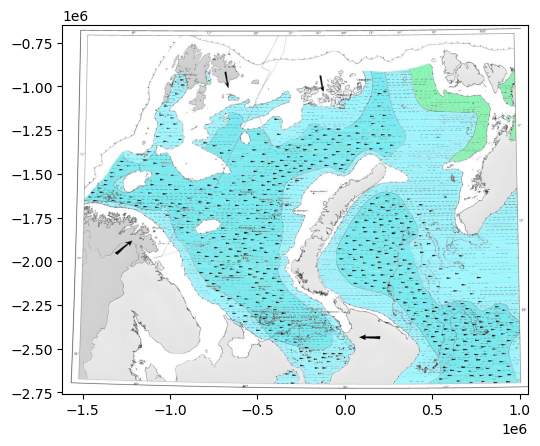

In [500]:
with rasterio.open(all_maps[0]) as dataset:
    crs = dataset.crs
    image_transform = dataset.transform
    show(dataset.read(), transform=dataset.transform)
    image = reshape_as_image(dataset.read().astype(rasterio.uint8))

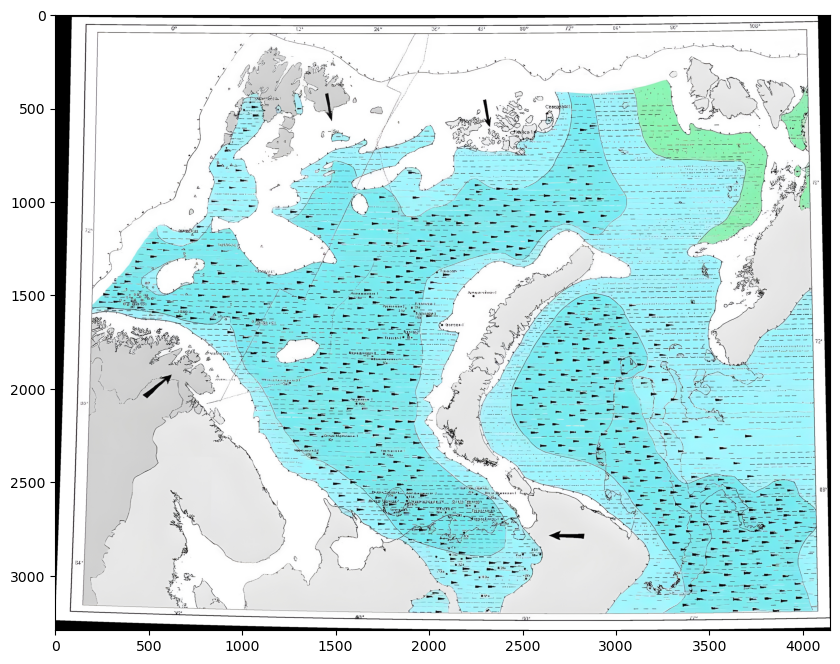

In [501]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

In [502]:
# print(dataset.nodatavals)
# print(dataset.nodata)
# print(dataset.read_masks())
# row, col = data.index(longitude, latitude)

# image = dataset.read().astype(rasterio.uint8)
# print(image)

# UR_y = np.where(image.argmax(1) != 0)[0][0]
# UR_x = image[UR_y].argmax()

# UL_x = np.where(image.argmax(0) != 0)[-1][0]
# UL_y = image[:, UL_x].argmax()

# LR_y = np.where(image.argmax(1) != 0)[-1][0]
# LR_x = image[LR_y].argmax()

# LL_x = np.where(image.argmax(0) != 0)[0][0]
# LL_y = image[:, LL_x].argmax()
# print(UR_x, UR_y)
# print(UL_x, UL_y)
# print(LR_x, LR_y)
# print(LL_x, LL_y)

# print(transform.estimate_transform("affine", )
# print(rowcol(dataset.transform, (left, right), (bottom, top)))
# show(dataset.read_masks())

In [503]:
image = image[:, :, :3]
image.shape

(3292, 4147, 3)

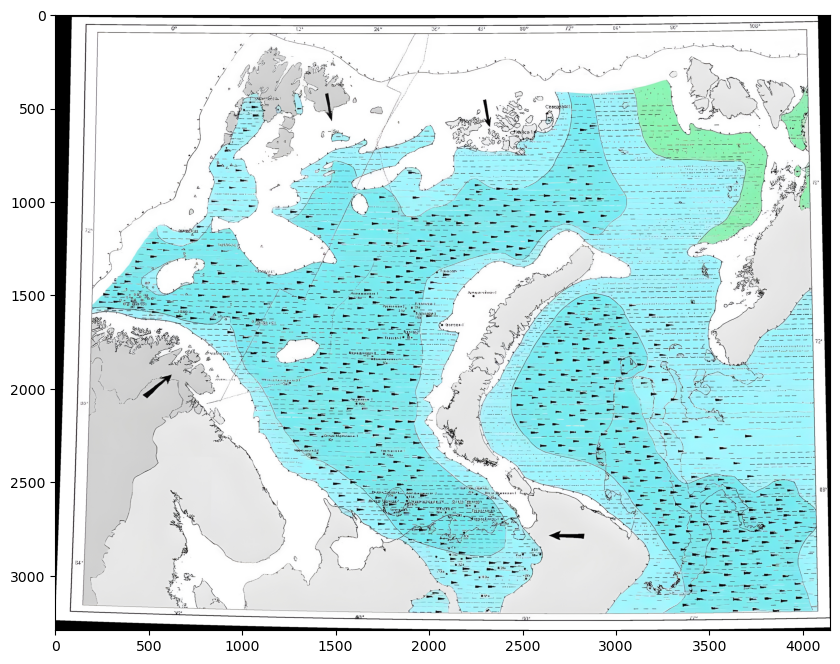

In [504]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

In [505]:
saved_image = image

In [507]:
if image.shape[0] > 3000 or image.shape[1] > 3000:
    ratio = 2
    image = transform.rescale(image, 1/ratio, anti_aliasing=True, channel_axis=-1)
    resized = True
else:
    resized = False

In [508]:
image.shape

(1646, 2074, 3)

In [509]:
image = exposure.equalize_adapthist(image, kernel_size = 8)
# image = filters.unsharp_mask(image, radius=2, amount=1)

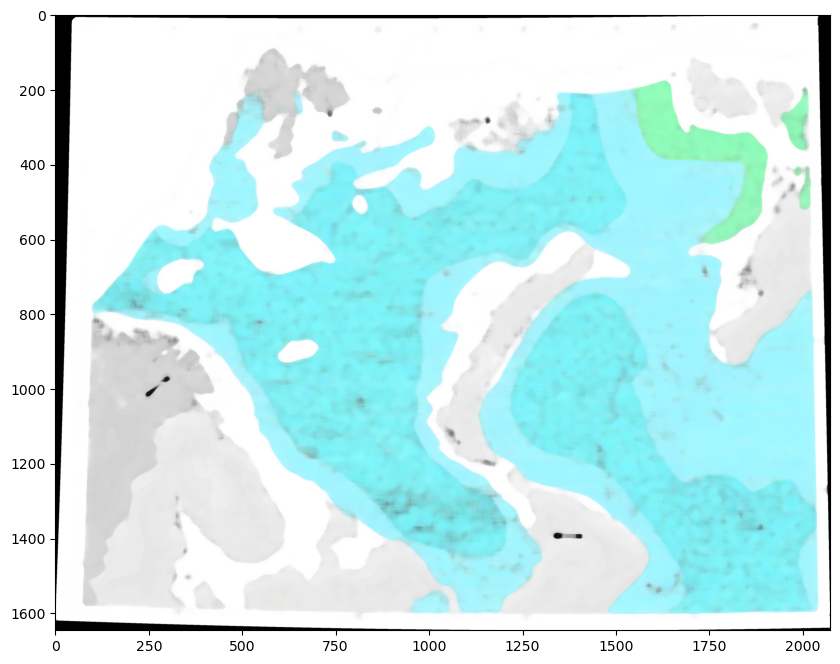

In [510]:
image = filters.median(image, np.ones((20, 20, 1)))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

In [511]:
img = color.rgb2lab(image).reshape((image.shape[1] * image.shape[0], image.shape[2]))  # rgb2lab

In [512]:
kmeans = KMeans(n_clusters=6).fit(img)

g:\miniconda3\envs\ap\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [513]:
centroid = kmeans.cluster_centers_
labels = kmeans.labels_

In [514]:
lab, percent = np.unique(labels, return_counts=True)
percent = percent/labels.shape[0]

In [515]:
colors = color.lab2rgb(centroid)
colors

array([[0.49884732, 0.92830922, 0.94639128],
       [0.99675427, 0.99751119, 0.99800709],
       [0.00539456, 0.00532584, 0.00545787],
       [0.57603729, 0.96704374, 0.72880051],
       [0.6397009 , 0.9538647 , 0.98621309],
       [0.88838624, 0.89048104, 0.89044937]])

In [516]:
lab

array([0, 1, 2, 3, 4, 5])

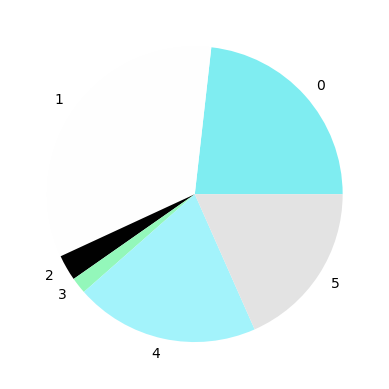

In [517]:
plt.pie(percent, colors=colors, labels=lab);

In [518]:
colors[0]

array([0.49884732, 0.92830922, 0.94639128])

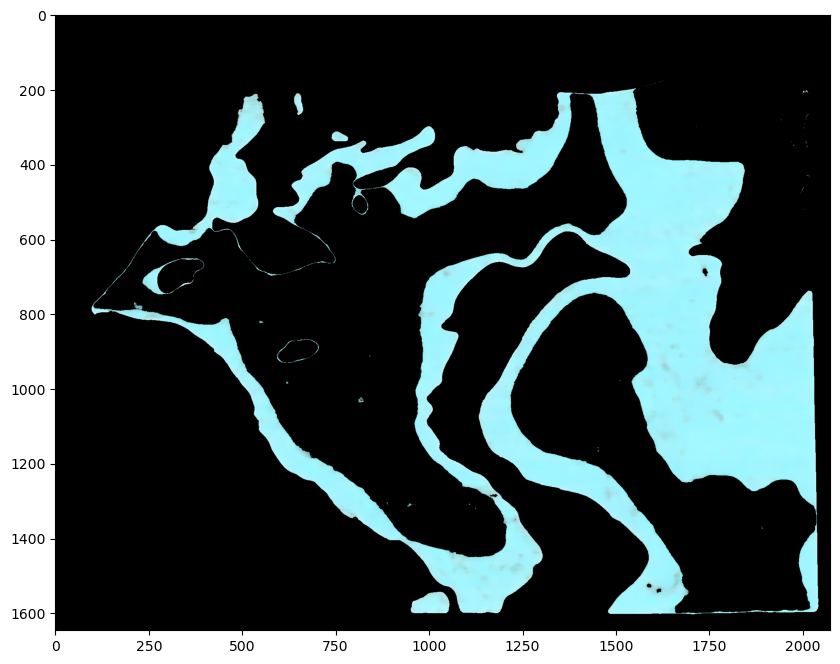

In [523]:
fig, ax = plt.subplots(figsize=(10, 10))
labels_array = np.array(labels).reshape(image.shape[0], image.shape[1])
label_bool = (labels_array == 4) #| (labels_array == 0)
ax.imshow(image * label_bool[:, :, None])

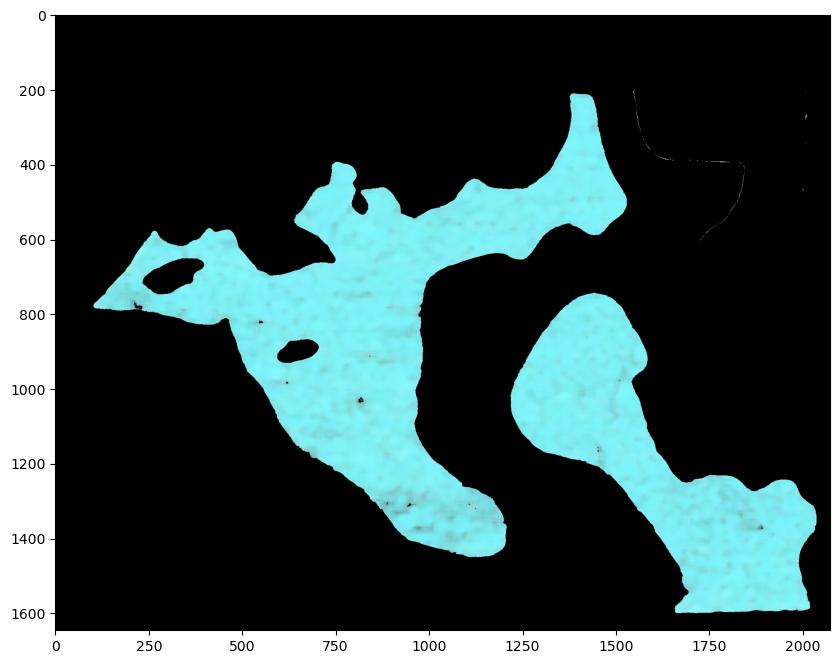

In [521]:
fig, ax = plt.subplots(figsize=(10, 10))
labels_array = np.array(labels).reshape(image.shape[0], image.shape[1])
label_bool = (labels_array == 0) #| (labels_array == 0)
ax.imshow(image * label_bool[:, :, None])

0

In [197]:
chosen_labels = [0, 4, 5]
zero_label = 3

1

In [111]:
chosen_labels = [2, 3, 4, 5]
zero_label = 0

2

In [312]:
chosen_labels = [1, 2, 3, 4, 5]
zero_label = 0

In [313]:
multipolygons_by_labels = []

In [314]:
for label in chosen_labels:
    label_bool = (labels_array == label)
    label_bool = np.fliplr(np.rot90(label_bool, k=3))
    binary = ndi.binary_fill_holes(label_bool, structure=np.ones((20, 10)))

    binary = filters.median(label_bool, np.ones((5, 5)))
    binary = morphology.remove_small_objects(binary, 100)
    binary = morphology.remove_small_holes(binary, 100)
    binary = morphology.binary_closing(binary, morphology.disk(5))

    binary = ndi.binary_fill_holes(binary)
    
    # for l in lab:
    #     if l != label:
    #         binary = binary & np.fliplr(np.rot90(~(labels_array == l), k=3))

    binary = binary & np.fliplr(np.rot90(~(labels_array == zero_label), k=3))
    
    contours = measure.find_contours(binary, 0.9)
    all_polygons = [geometry.Polygon(contour) for contour in contours]
    mean_area = np.mean([poly.area for poly in all_polygons])
    final_polygons = []

    poly_real = all_polygons[0]
    for poly_check in all_polygons[1:]:
        if not poly_real.contains(poly_check) and poly_check.area >= mean_area:
            final_polygons.append(poly_check)
        else:
            poly_real = poly_real.difference(poly_check)
    final_polygons.append(poly_real)

    multi_poly = geometry.MultiPolygon(final_polygons)
    multipolygons_by_labels.append(multi_poly)

In [315]:
if resized:
    final_transform = np.array(image_transform.to_shapely()) * np.array([2, 1, 1, 2, 1, 1])
else:
    final_transform = np.array(image_transform.to_shapely())
final_transform

array([ 8.54036448e+02,  0.00000000e+00,  0.00000000e+00, -8.53961762e+02,
       -1.69223367e+06, -5.38782921e+05])

In [316]:
gdf = gpd.GeoSeries(multipolygons_by_labels, crs=crs)
gdf = gdf.affine_transform(final_transform)
# Optional
gdf = gdf.buffer(5, join_style=1).buffer(-5, join_style=1)

In [317]:
gdf = gpd.GeoDataFrame({'new_column': [0 for _ in range(gdf.shape[0])], "geometry": gdf})

In [318]:
gdf

new_column                                           geometry
0           0  MULTIPOLYGON (((-325860.749 -2145084.994, -325...
1           0  POLYGON ((-1534322.323 -1712980.342, -1534322....
2           0  MULTIPOLYGON (((-154199.423 -1861569.688, -154...
3           0  MULTIPOLYGON (((-1355828.706 -1696755.068, -13...
4           0  MULTIPOLYGON (((-1085953.188 -1054575.823, -10...

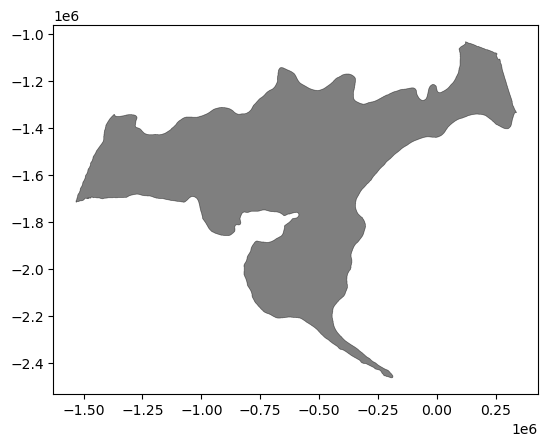

In [321]:
gdf.loc[[1]].plot(
    alpha=0.5,
    color=colors[0],
    edgecolor="black",
    linewidth=0.5,
);

In [322]:
gdf.to_file("Map 3.shp", encoding="utf-8")

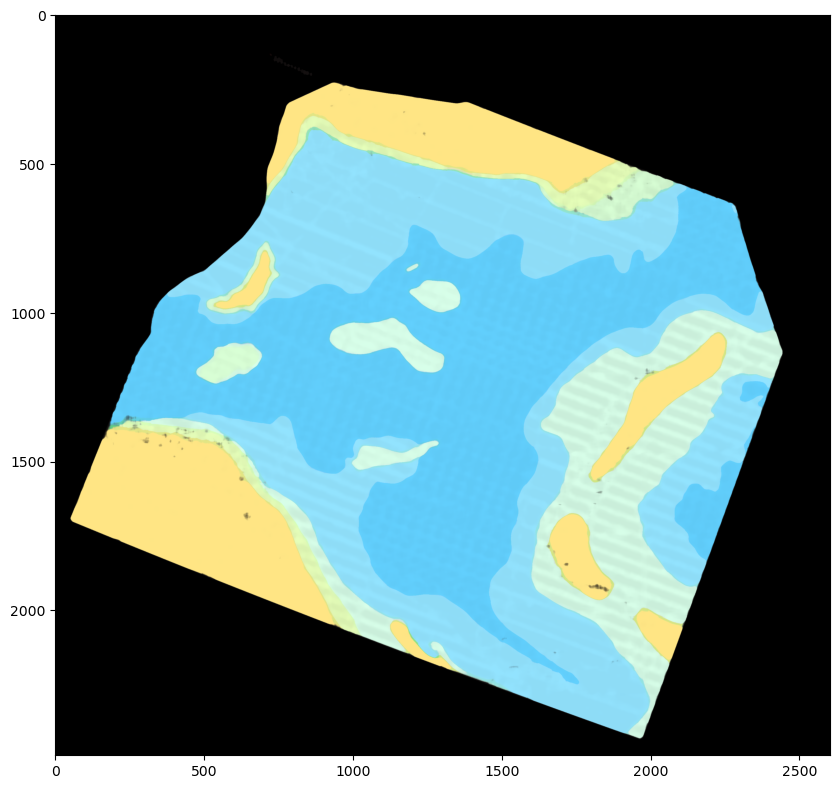

In [344]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)

In [345]:
tectonic_sib = gpd.read_file("../Карты/Тектоническое строение/Структуры_Сибирь.shp").rename(columns={"name_rus": "Name Russian", "Name_eng": "Name English"})
tectonic_smng = gpd.read_file("../Карты/Тектоническое строение/Структуры_СМНГ.shp").rename(columns={"Name_rus": "Name Russian", "Name":"Name English"})
tectonic = pd.concat([tectonic_sib, tectonic_smng]).loc[:, ["Name Russian", "Name English", "geometry"]]

In [346]:
tectonic

Name Russian                           Name English  \
0    Казахстанская складчатая област                       Kazahstan upland   
1   Средне-Уральская моноклиналь (ге                  Middle Ural monocline   
2    Среднеобская система сводовых п  West Siberia continental rifting zone   
3                      Полярный Урал                             Polar Ural   
4       Предуральский краевой прогиб                          Ural foreland   
..                               ...                                    ...   
51               поднятие Бъярмелэнд                     Bjarmeland plaform   
52        Северо-Баренцевская депрес               North-Barents depression   
53               Земля Франса Иосифа                       Franz Josef high   
54        Альбановского-Горбовский п            Albanovsko-Gorbovsky saddle   
55                Прогиб Святой Анны                        St. Anna trough   

                                             geometry  
0   POLYGON ((-1153922.866 2539707.573, -1175152.6...  
1   POLYGON ((-1570061.564 3570935.581, -1555494.1...  
2   POLYGON ((-1199833.170 3912807.752, -1162921.1...  
3   POLYGON ((-1125669.610 4326595.404, -1127192.0...  
4   POLYGON ((-1965342.854 3834917.992, -1957381.2...  
..                                                ...  
51  POLYGON ((-2242748.876 5666220.353, -2251812.0...  
52  POLYGON ((-1298552.206 5822450.291, -1296926.6...  
53  POLYGON ((-1385472.028 6021895.342, -1378418.1...  
54  POLYGON ((-1045308.344 5783567.673, -1040446.6...  
55  POLYGON ((-735312.243 5883654.634, -716427.472...  

[124 rows x 3 columns]

In [347]:
wells_older = gpd.read_file("../Карты/Extra Layers/J3 Wells and older/J3_and_older.shp")
outcrops = gpd.read_file("../Карты/Extra Layers/Выходы J3 пород/J.shp")
land = gpd.read_file("../Карты/Extra Layers/Countries IRIS21/Countries_IRIS21_Intersect_2.shp")

In [348]:
# wells_barents.to_file()

In [581]:
wells_barents = gpd.read_file("../Карты/Barents Sea wells/Barents sea wells.shp")
# wells_russian = gpd.read_file("../Карты/Barents Sea wells/Russian wells.shp", encoding='cp1251')

In [586]:
wells_barents

WELL_NAME                 Name  \
0             Shtokmanovskaya 1      ????????????? 1   
1              Kurentsovskaya 1       ???????????? 1   
2    Krestovaya (Barents Sea) 1          ????????? 1   
3     Arkticheskaya (Barents) 1        ??????????? 1   
4       Murmanskaya Severnaya 1  ??????-?????????? 1   
..                          ...                  ...   
115                    7316/5-1             7316/5-1   
116                    7321/7-1             7321/7-1   
117                    7321/8-1             7321/8-1   
118                    7321/9-1             7321/9-1   
119                   7324/10-1            7324/10-1   

                      geometry  
0    POINT (44.22652 72.99281)  
1    POINT (47.37917 70.46111)  
2    POINT (50.53556 74.52500)  
3    POINT (43.77583 71.77806)  
4    POINT (41.55250 70.50000)  
..                         ...  
115  POINT (16.43127 73.52017)  
116  POINT (21.07380 73.43233)  
117  POINT (21.41425 73.33689)  
118  POINT (21.68189 73.26893)  
119  POINT (24.31177 73.16398)  

[120 rows x 3 columns]

In [587]:
data = pd.read_csv("new_stats.csv").rename(columns={"Well": "WELL_NAME"})

In [589]:
wells_barents.merge(data, on="WELL_NAME")

WELL_NAME                 Name                   geometry  \
0         Shtokmanovskaya 1      ????????????? 1  POINT (44.22652 72.99281)   
1   Murmanskaya Severnaya 1  ??????-?????????? 1  POINT (41.55250 70.50000)   
2         Shtokmanovskaya 4      ????????????? 4  POINT (44.45330 73.14555)   
3             Ludlovskaya 2         ?????????? 2  POINT (47.22028 74.73250)   
4          Fersmanovskaya 1      ????????????? 1  POINT (42.35333 74.65528)   
5         Shtokmanovskaya 5      ????????????? 5  POINT (43.58252 73.14905)   
6                  7019/1-1             7019/1-1  POINT (19.07122 70.91818)   
7                  7119/9-1             7119/9-1  POINT (19.82700 71.41491)   
8                 7119/12-2            7119/12-2  POINT (19.97081 71.01450)   
9                  7120/2-2             7120/2-2  POINT (20.59932 71.84015)   
10                 7120/7-2             7120/7-2  POINT (20.32733 71.31999)   
11                 7120/7-3             7120/7-3  POINT (20.17790 71.46217)   
12                 7120/8-2             7120/8-2  POINT (20.46436 71.33783)   
13                 7120/9-1             7120/9-1  POINT (20.94545 71.49086)   
14                7120/12-1            7120/12-1  POINT (20.75399 71.11366)   
15                7120/12-2            7120/12-2  POINT (20.80367 71.12521)   
16                 7121/4-1             7121/4-1  POINT (21.15471 71.60006)   
17                 7122/2-1             7122/2-1  POINT (22.64290 71.96137)   
18                 7122/4-1             7122/4-1  POINT (22.08353 71.74752)   
19                 7122/6-1             7122/6-1  POINT (22.81036 71.63887)   
20                 7122/7-3             7122/7-3  POINT (22.26641 71.25501)   
21                 7124/3-1             7124/3-1  POINT (24.77913 71.76019)   
22                7124/4-1S            7124/4-1S  POINT (24.09765 71.58799)   
23                 7125/1-1             7125/1-1  POINT (25.18631 71.89026)   
24                 7224/7-1             7224/7-1  POINT (24.29943 72.28529)   
25                 7226/2-1             7226/2-1  POINT (26.59301 72.89235)   
26                7226/11-1            7226/11-1  POINT (26.47784 72.23859)   
27                7228/9-1S            7228/9-1S  POINT (28.71794 72.39700)   
28                7229/11-1            7229/11-1  POINT (29.64052 72.21613)   
29                 7321/7-1             7321/7-1  POINT (21.07380 73.43233)   
30                 7321/8-1             7321/8-1  POINT (21.41425 73.33689)   
31                 7321/9-1             7321/9-1  POINT (21.68189 73.26893)   

      HIo  TOCo  
0   311.4   4.4  
1   328.5   8.9  
2   288.3  14.2  
3   190.0   0.9  
4   380.0  10.2  
5    90.0   0.8  
6   240.0   4.3  
7   190.0   3.4  
8   232.0   5.3  
9   300.2   9.1  
10  257.8   5.8  
11  266.7  15.1  
12  300.0   5.4  
13  320.0   6.3  
14  294.6   5.7  
15  337.4   6.3  
16  310.0   8.7  
17  270.3   9.2  
18  283.2  10.0  
19  344.2  12.3  
20  179.4  14.0  
21  250.7   8.8  
22  336.0   9.2  
23  351.4  12.8  
24  396.1   5.6  
25  338.0   4.3  
26  369.8   7.3  
27  316.2   8.5  
28  384.0   9.7  
29  171.8  10.6  
30  266.5   4.7  
31  245.1   3.2

In [590]:
data.shape

(41, 3)

In [350]:
# wells_russian

In [351]:
# wells_barents

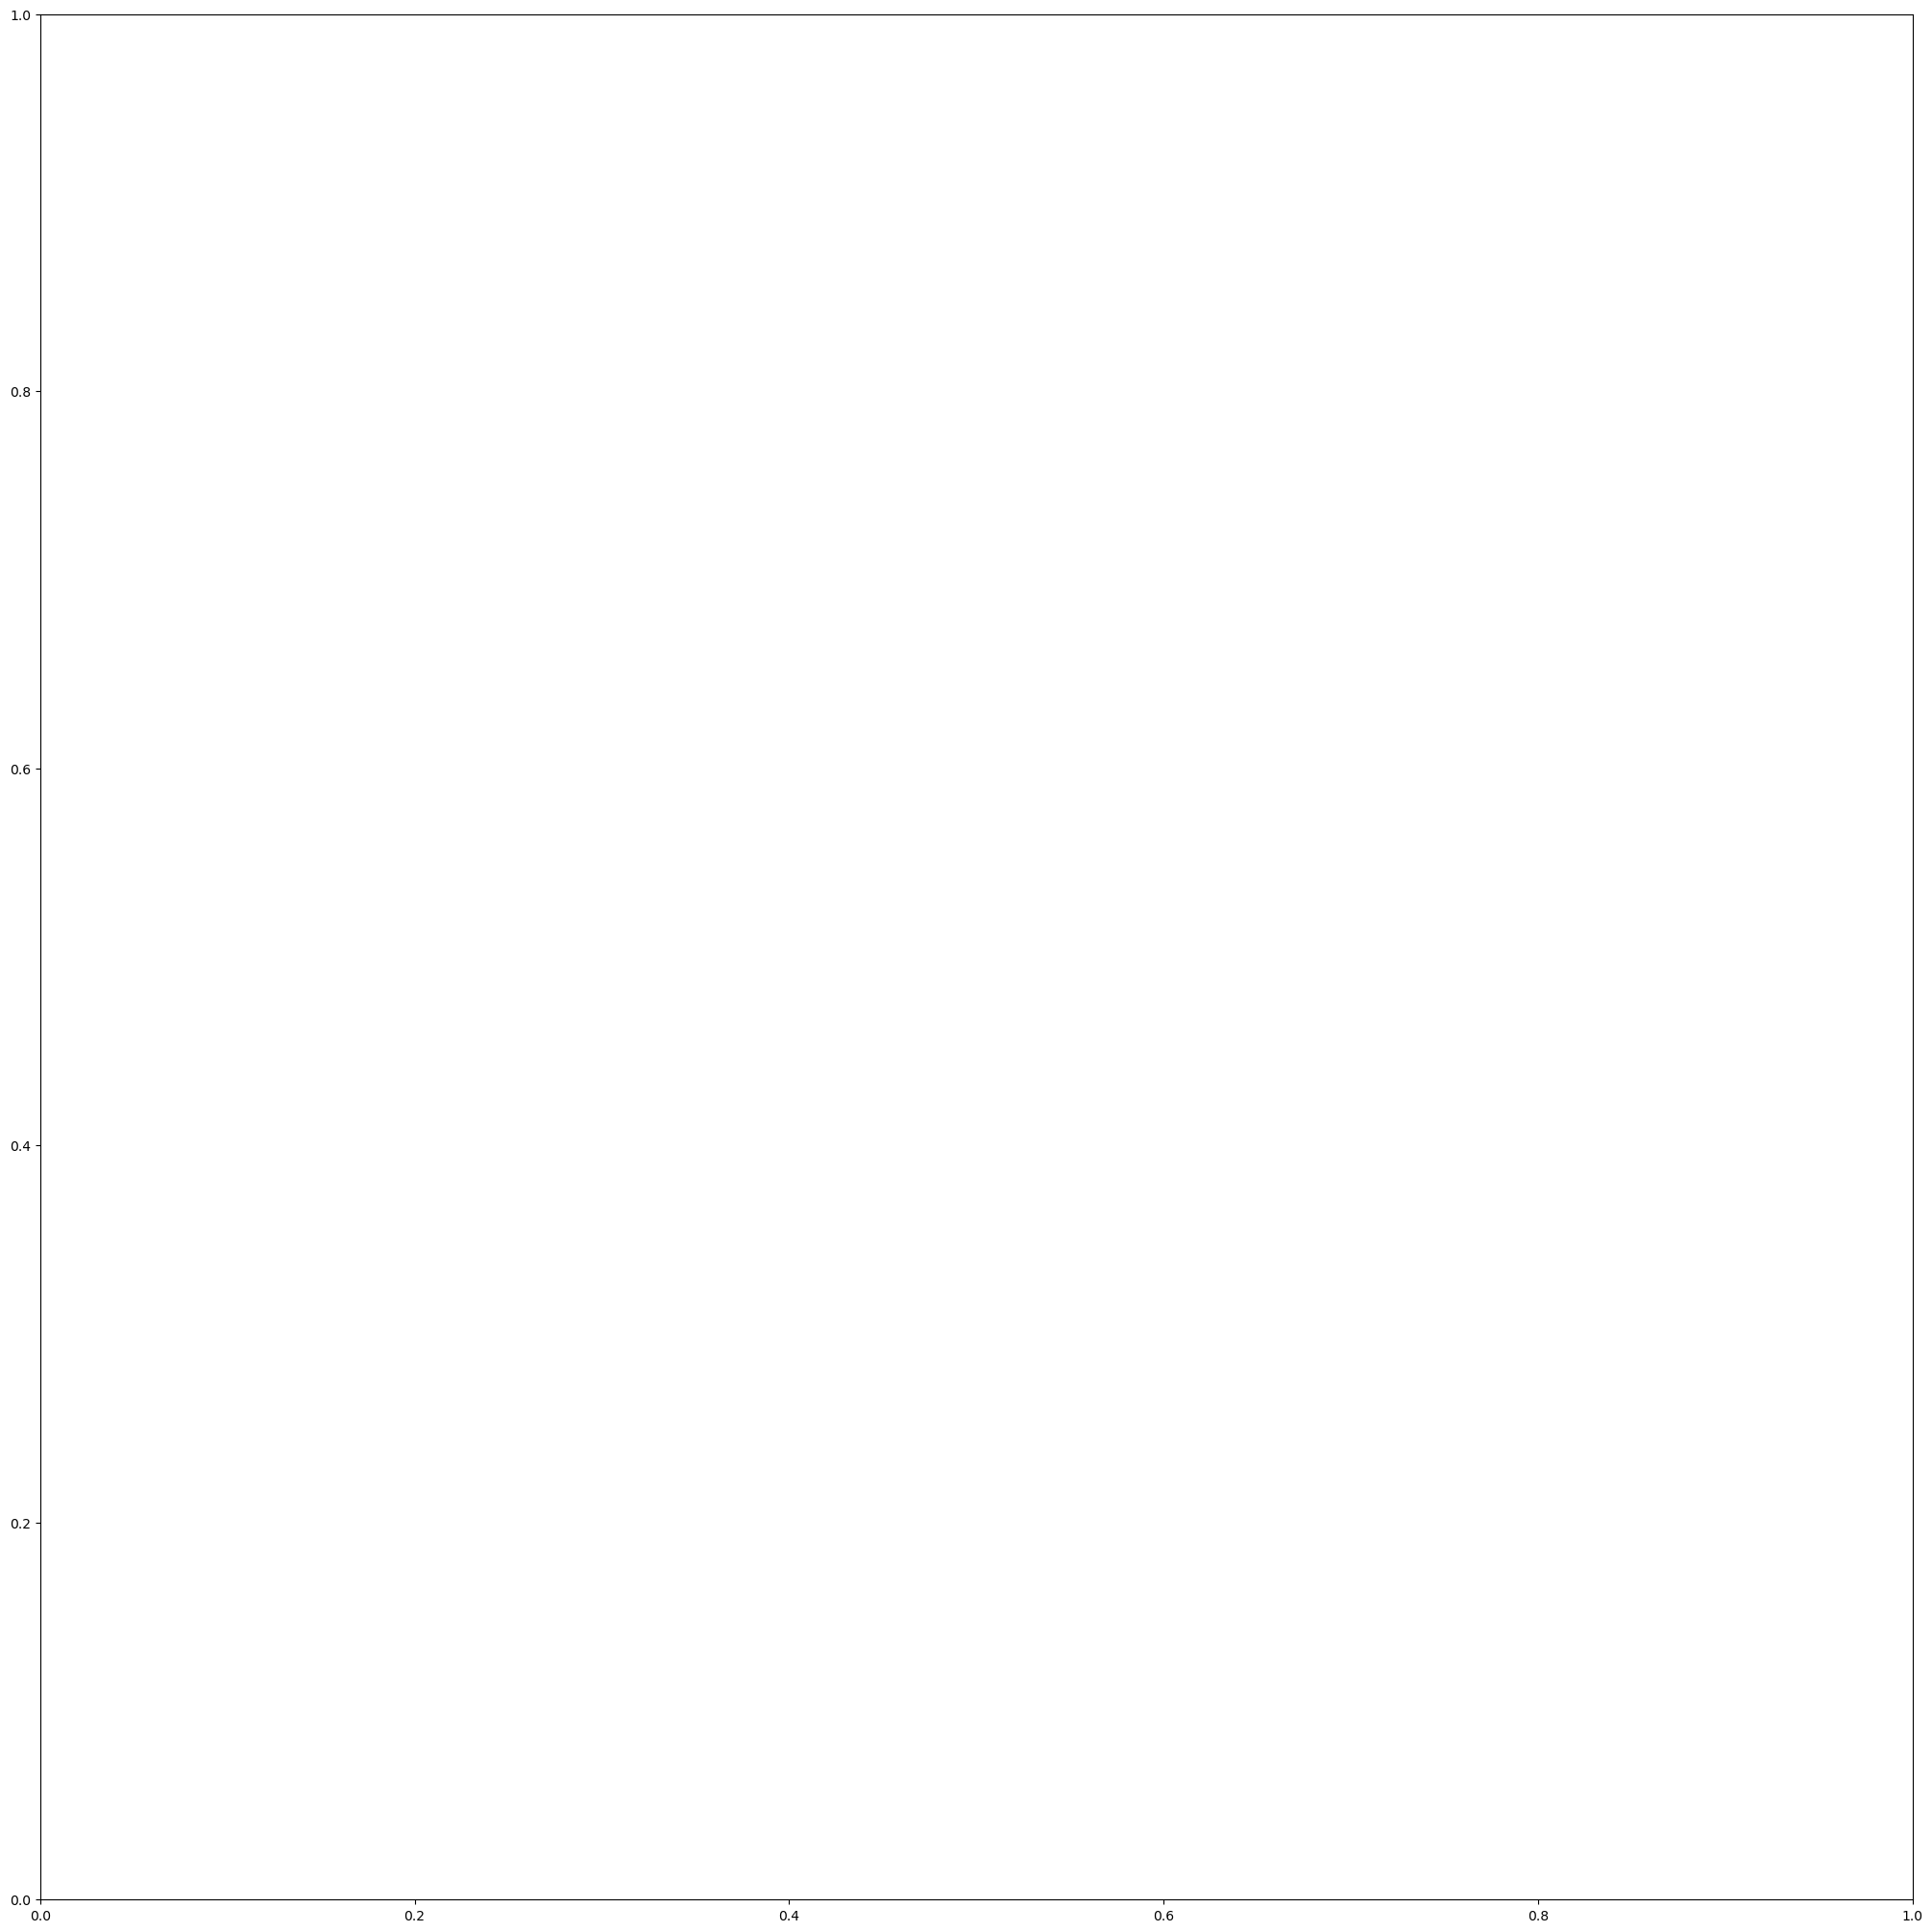

In [352]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')
legend_label = []

In [353]:
tectonic.boundary.to_crs(crs).plot(edgecolor="black", facecolor=None, color=None, linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [354]:
# tectonic.to_crs(crs).apply(lambda x: ax.annotate(text=x['Name Russian'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

In [355]:
land.to_crs(crs).plot(edgecolor="black", facecolor="wheat", linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [356]:
gdf.iloc[[1]].dissolve().plot(
    alpha=0.5,
    color="lightskyblue",
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    legend=True
);
legend_label.append(Patch(alpha=0.5, facecolor='lightskyblue', edgecolor='black', label=fill("Прогнозная область распространения верхнеюрских НГМТ", 20)))

<Figure size 640x480 with 0 Axes>

In [357]:
outcrops.to_crs(crs).plot(edgecolor="black", color="blue", linewidth=0.5, ax=ax);
legend_label.append(Patch(facecolor='blue', edgecolor='black', label=fill("Выходы юрских пород на поверхность", 20)))

<Figure size 640x480 with 0 Axes>

In [358]:
wells_older.to_crs(crs).plot(edgecolor="black", facecolor="black", linewidth=4, ax=ax)
legend_label.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="black",
        label=fill("Скважины, вскрывшие верхнеюрские отложения", 20),
        markerfacecolor="black",
        markersize=16,
        ls="",
    )
)

<Figure size 640x480 with 0 Axes>

In [359]:
# data_wells.to_crs(crs).plot(edgecolor="black", facecolor="red", linewidth=2, ax=ax);
# for row in data_wells.to_crs(crs).iterrows():
#     x, y = row["geometry"].geometry.xy
#     label = row["HIo"]
#     ax.annotate(label, xy=(x, y), xytext=(10, 10), textcoords="offset points")

# legend_label.append(
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="red",
#         label=fill("Значения по скважинам, средние", 20),
#         markerfacecolor="black",
#         markersize=16,
#         ls="",
#     )
# )

In [360]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

In [361]:
ax.tick_params(axis='both', labelsize=14)

In [362]:
ax.legend(
    handles=legend_label,
    title="Условные обозначения",
    fontsize=16,
    title_fontsize=20,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.0,
    frameon=False,
    handleheight=2, handlelength=3
)

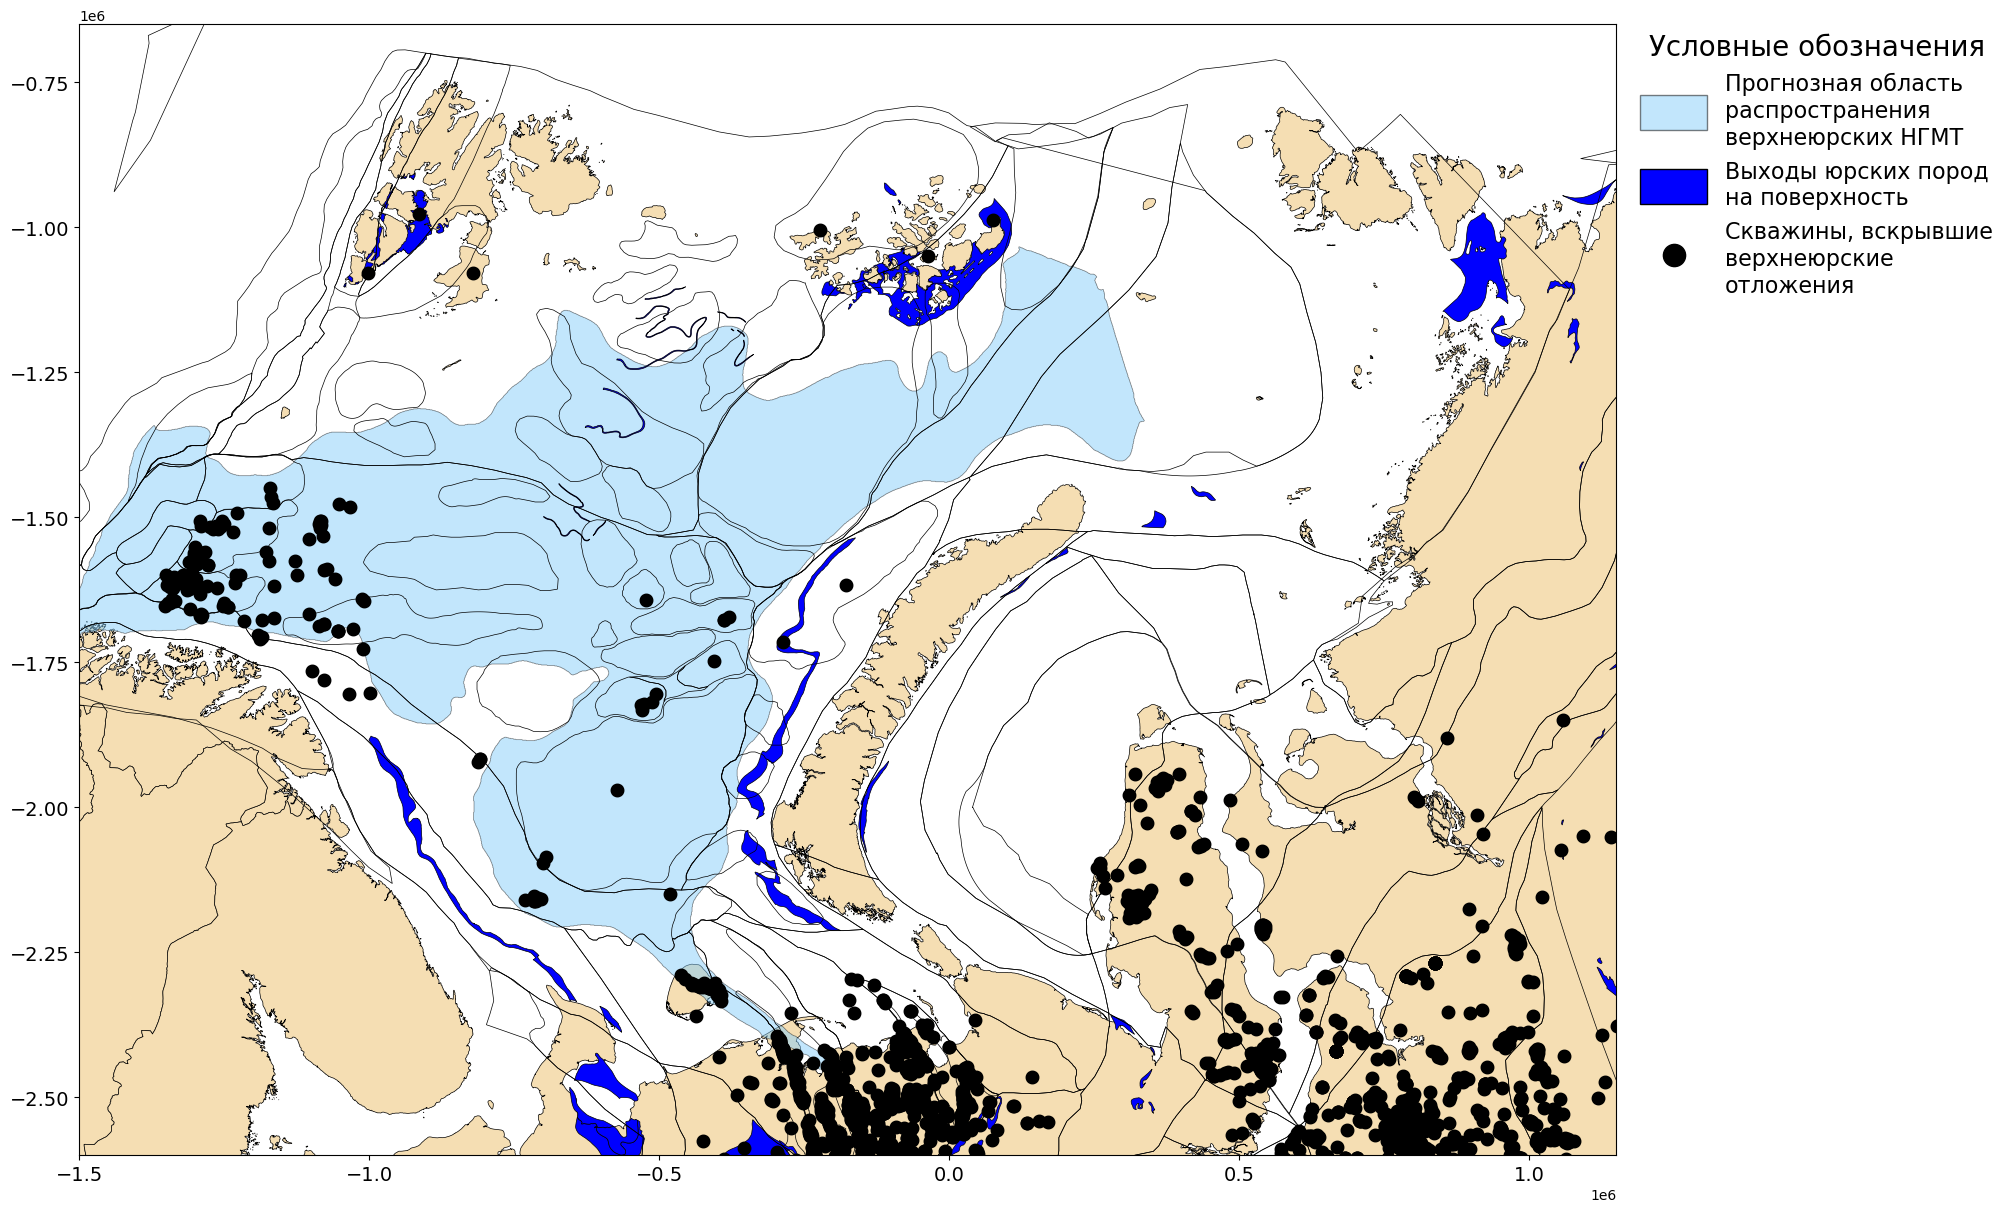

In [363]:
fig

In [312]:
# overlay = gpd.overlay(gdf.to_crs(tectonic.crs).to_frame(), tectonic)
# overlay.plot(edgecolor="black", facecolor=None, color=None)

# Общие области

In [591]:
first_map = gpd.read_file("Map 1.shp").loc[[2]]
second_map = gpd.read_file("Map 2.shp").loc[[0]]
third_map = gpd.read_file("Map 3.shp").loc[[1]]

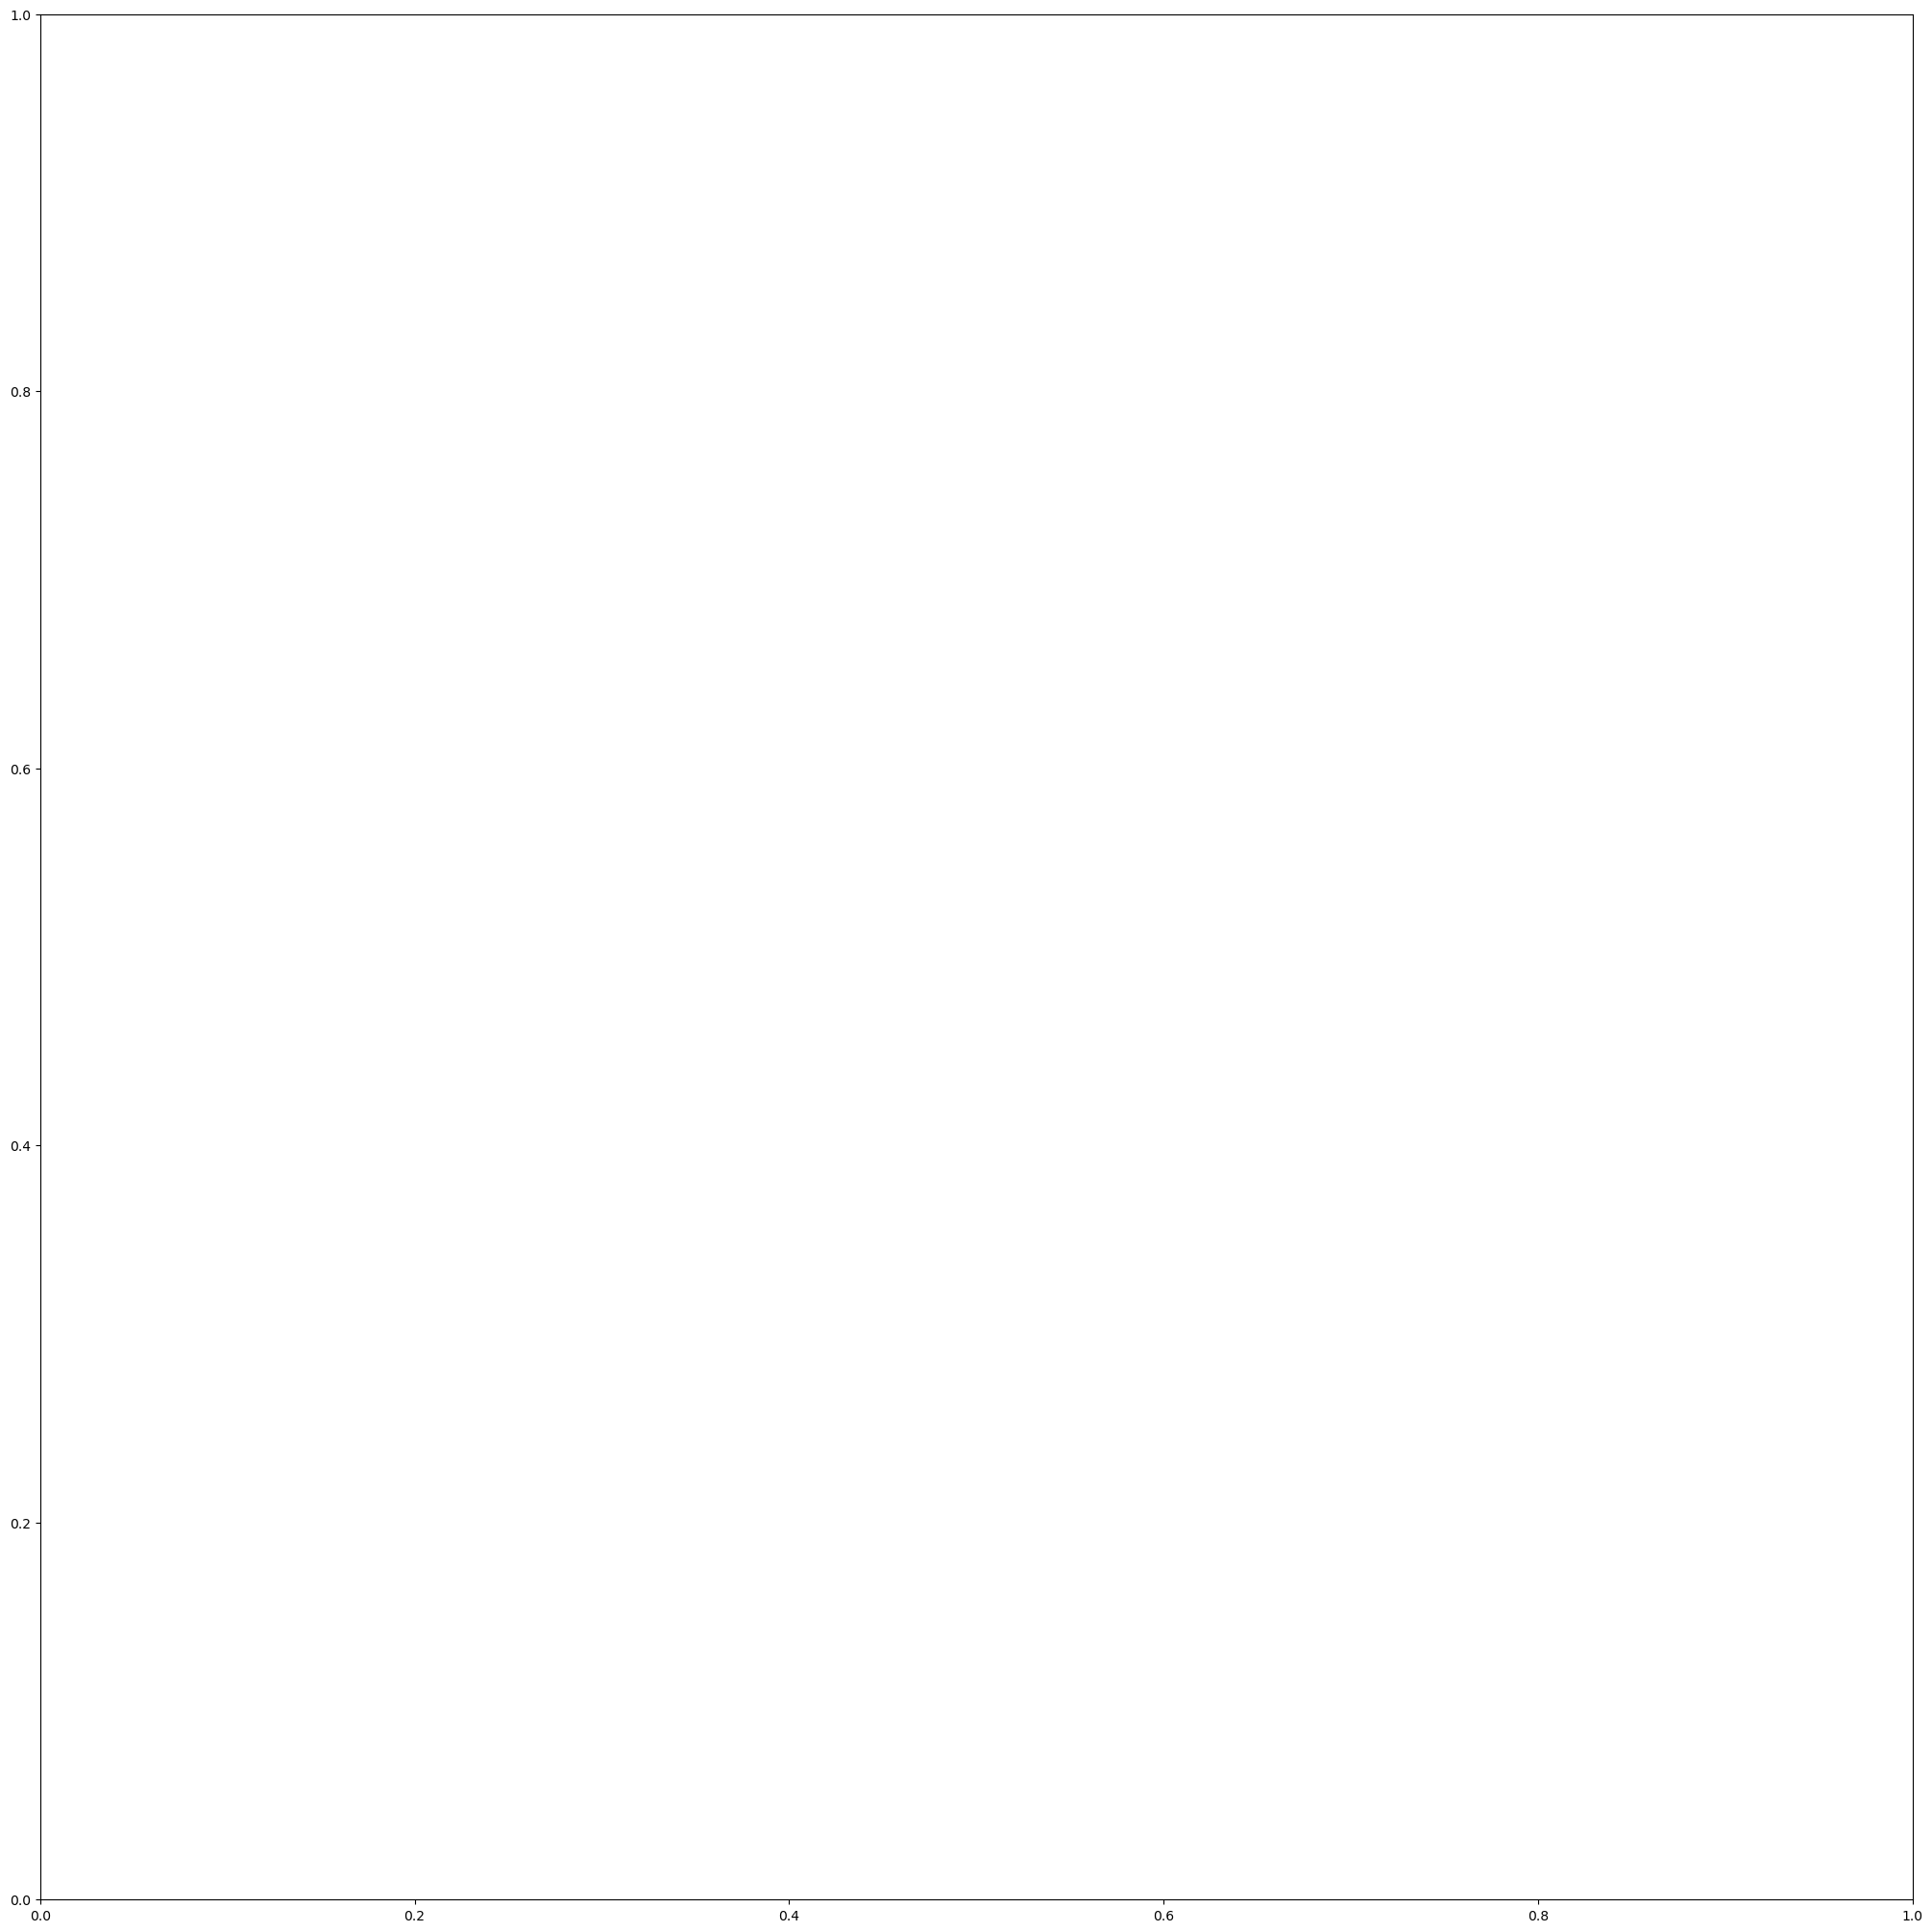

In [592]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')

In [593]:
first_map.loc[[2]].plot(
    alpha=0.5,
    color="lightskyblue",
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    label="Прогнозная область распространения верхнеюрских НГМТ",
)

<Axes: >

<Figure size 640x480 with 0 Axes>

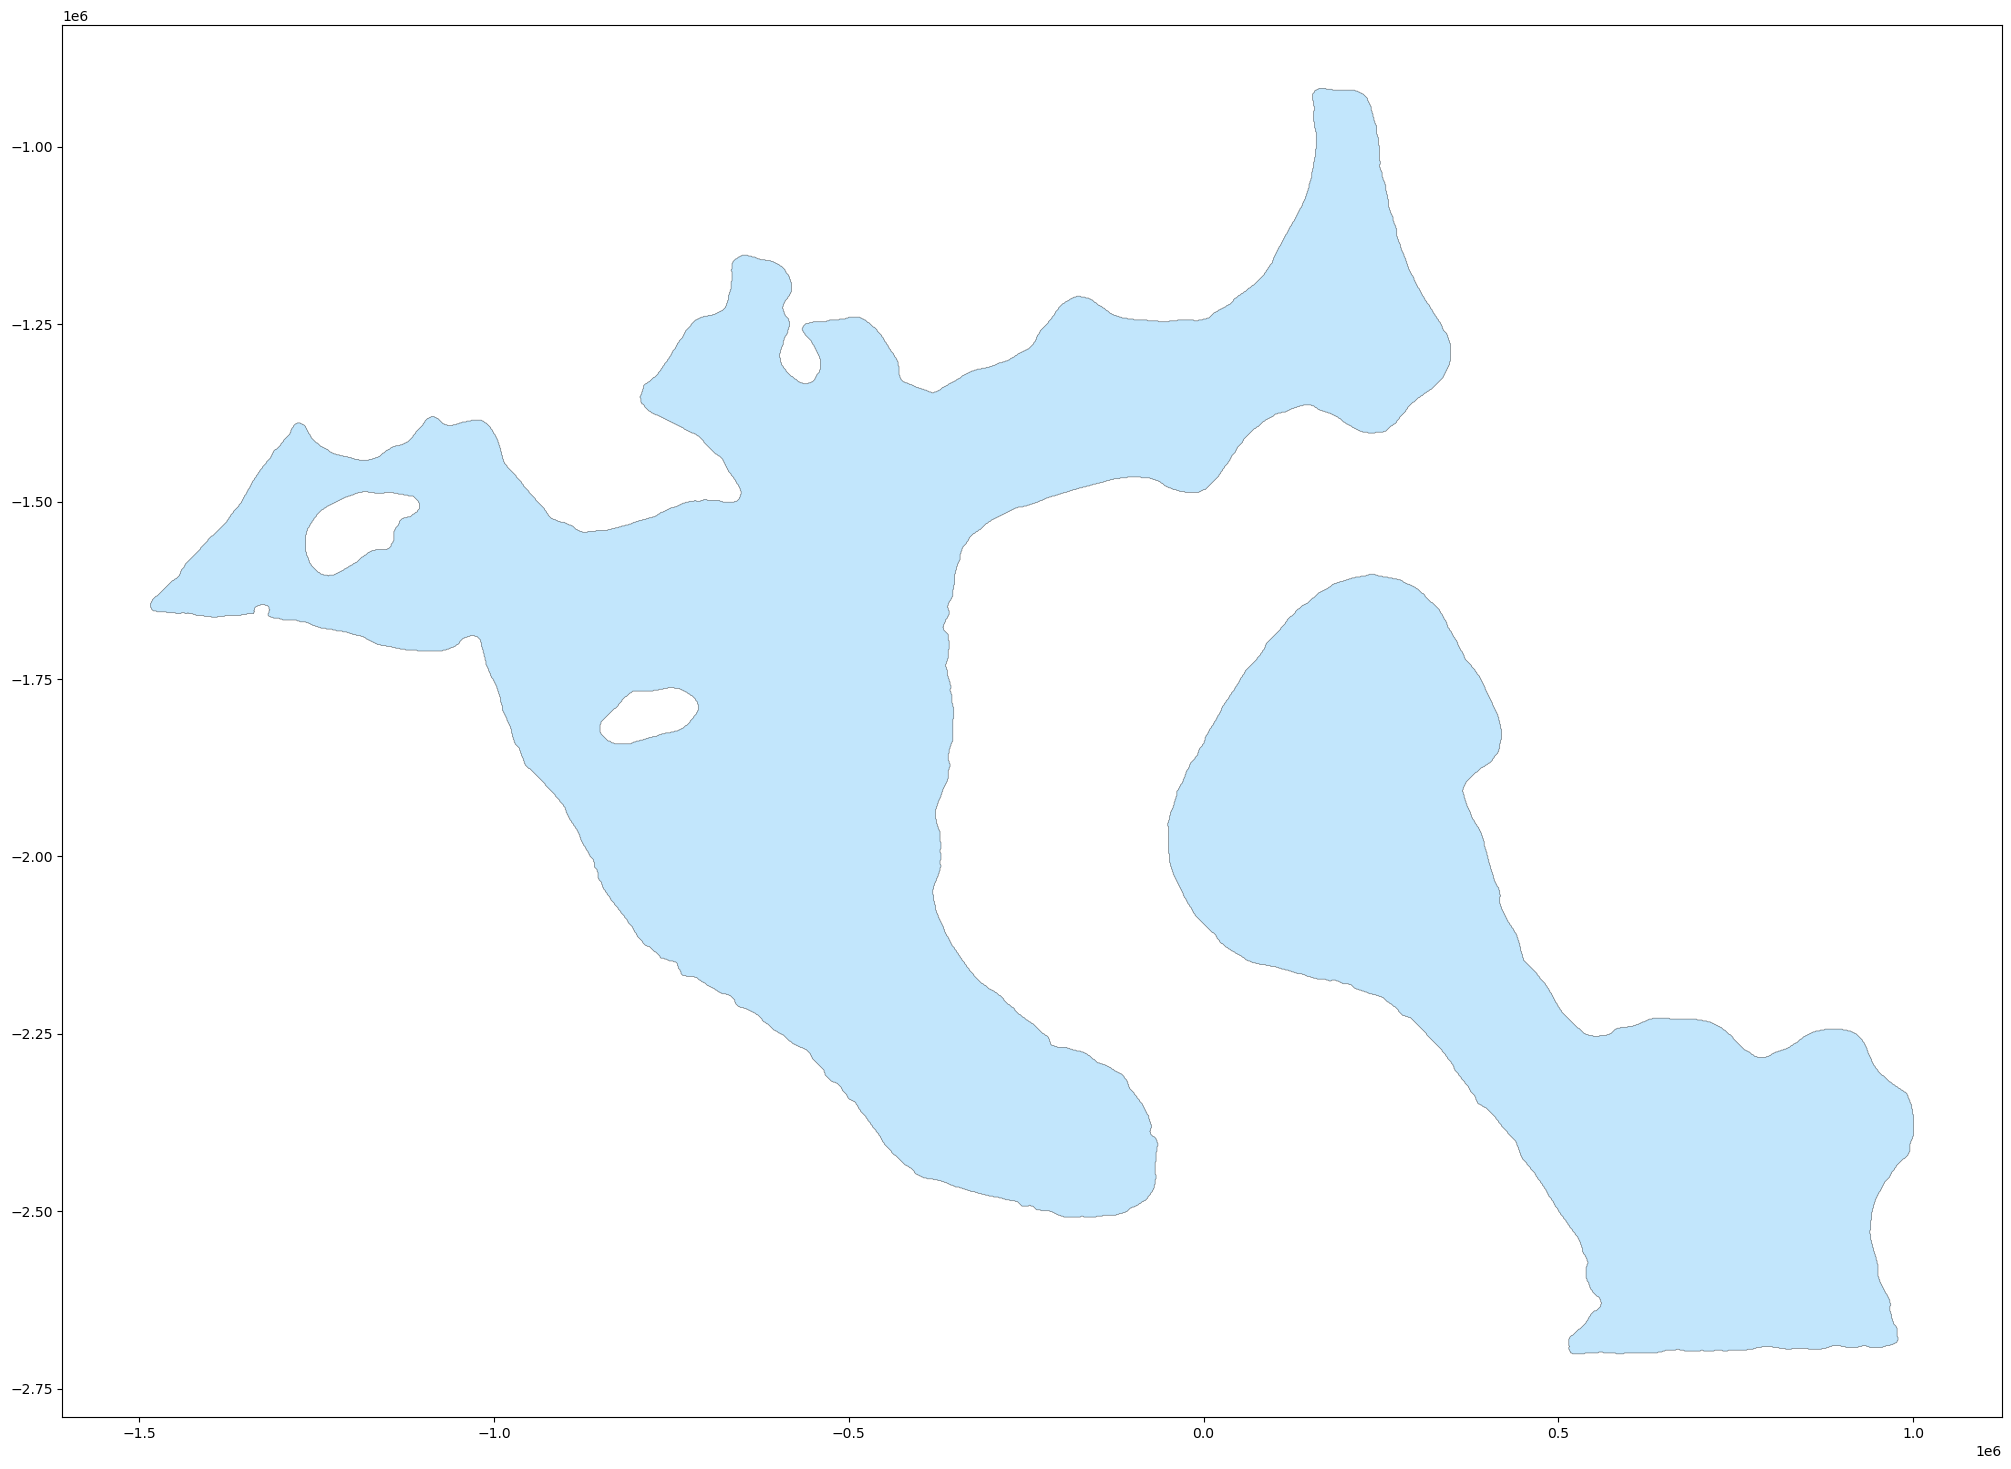

In [594]:
fig

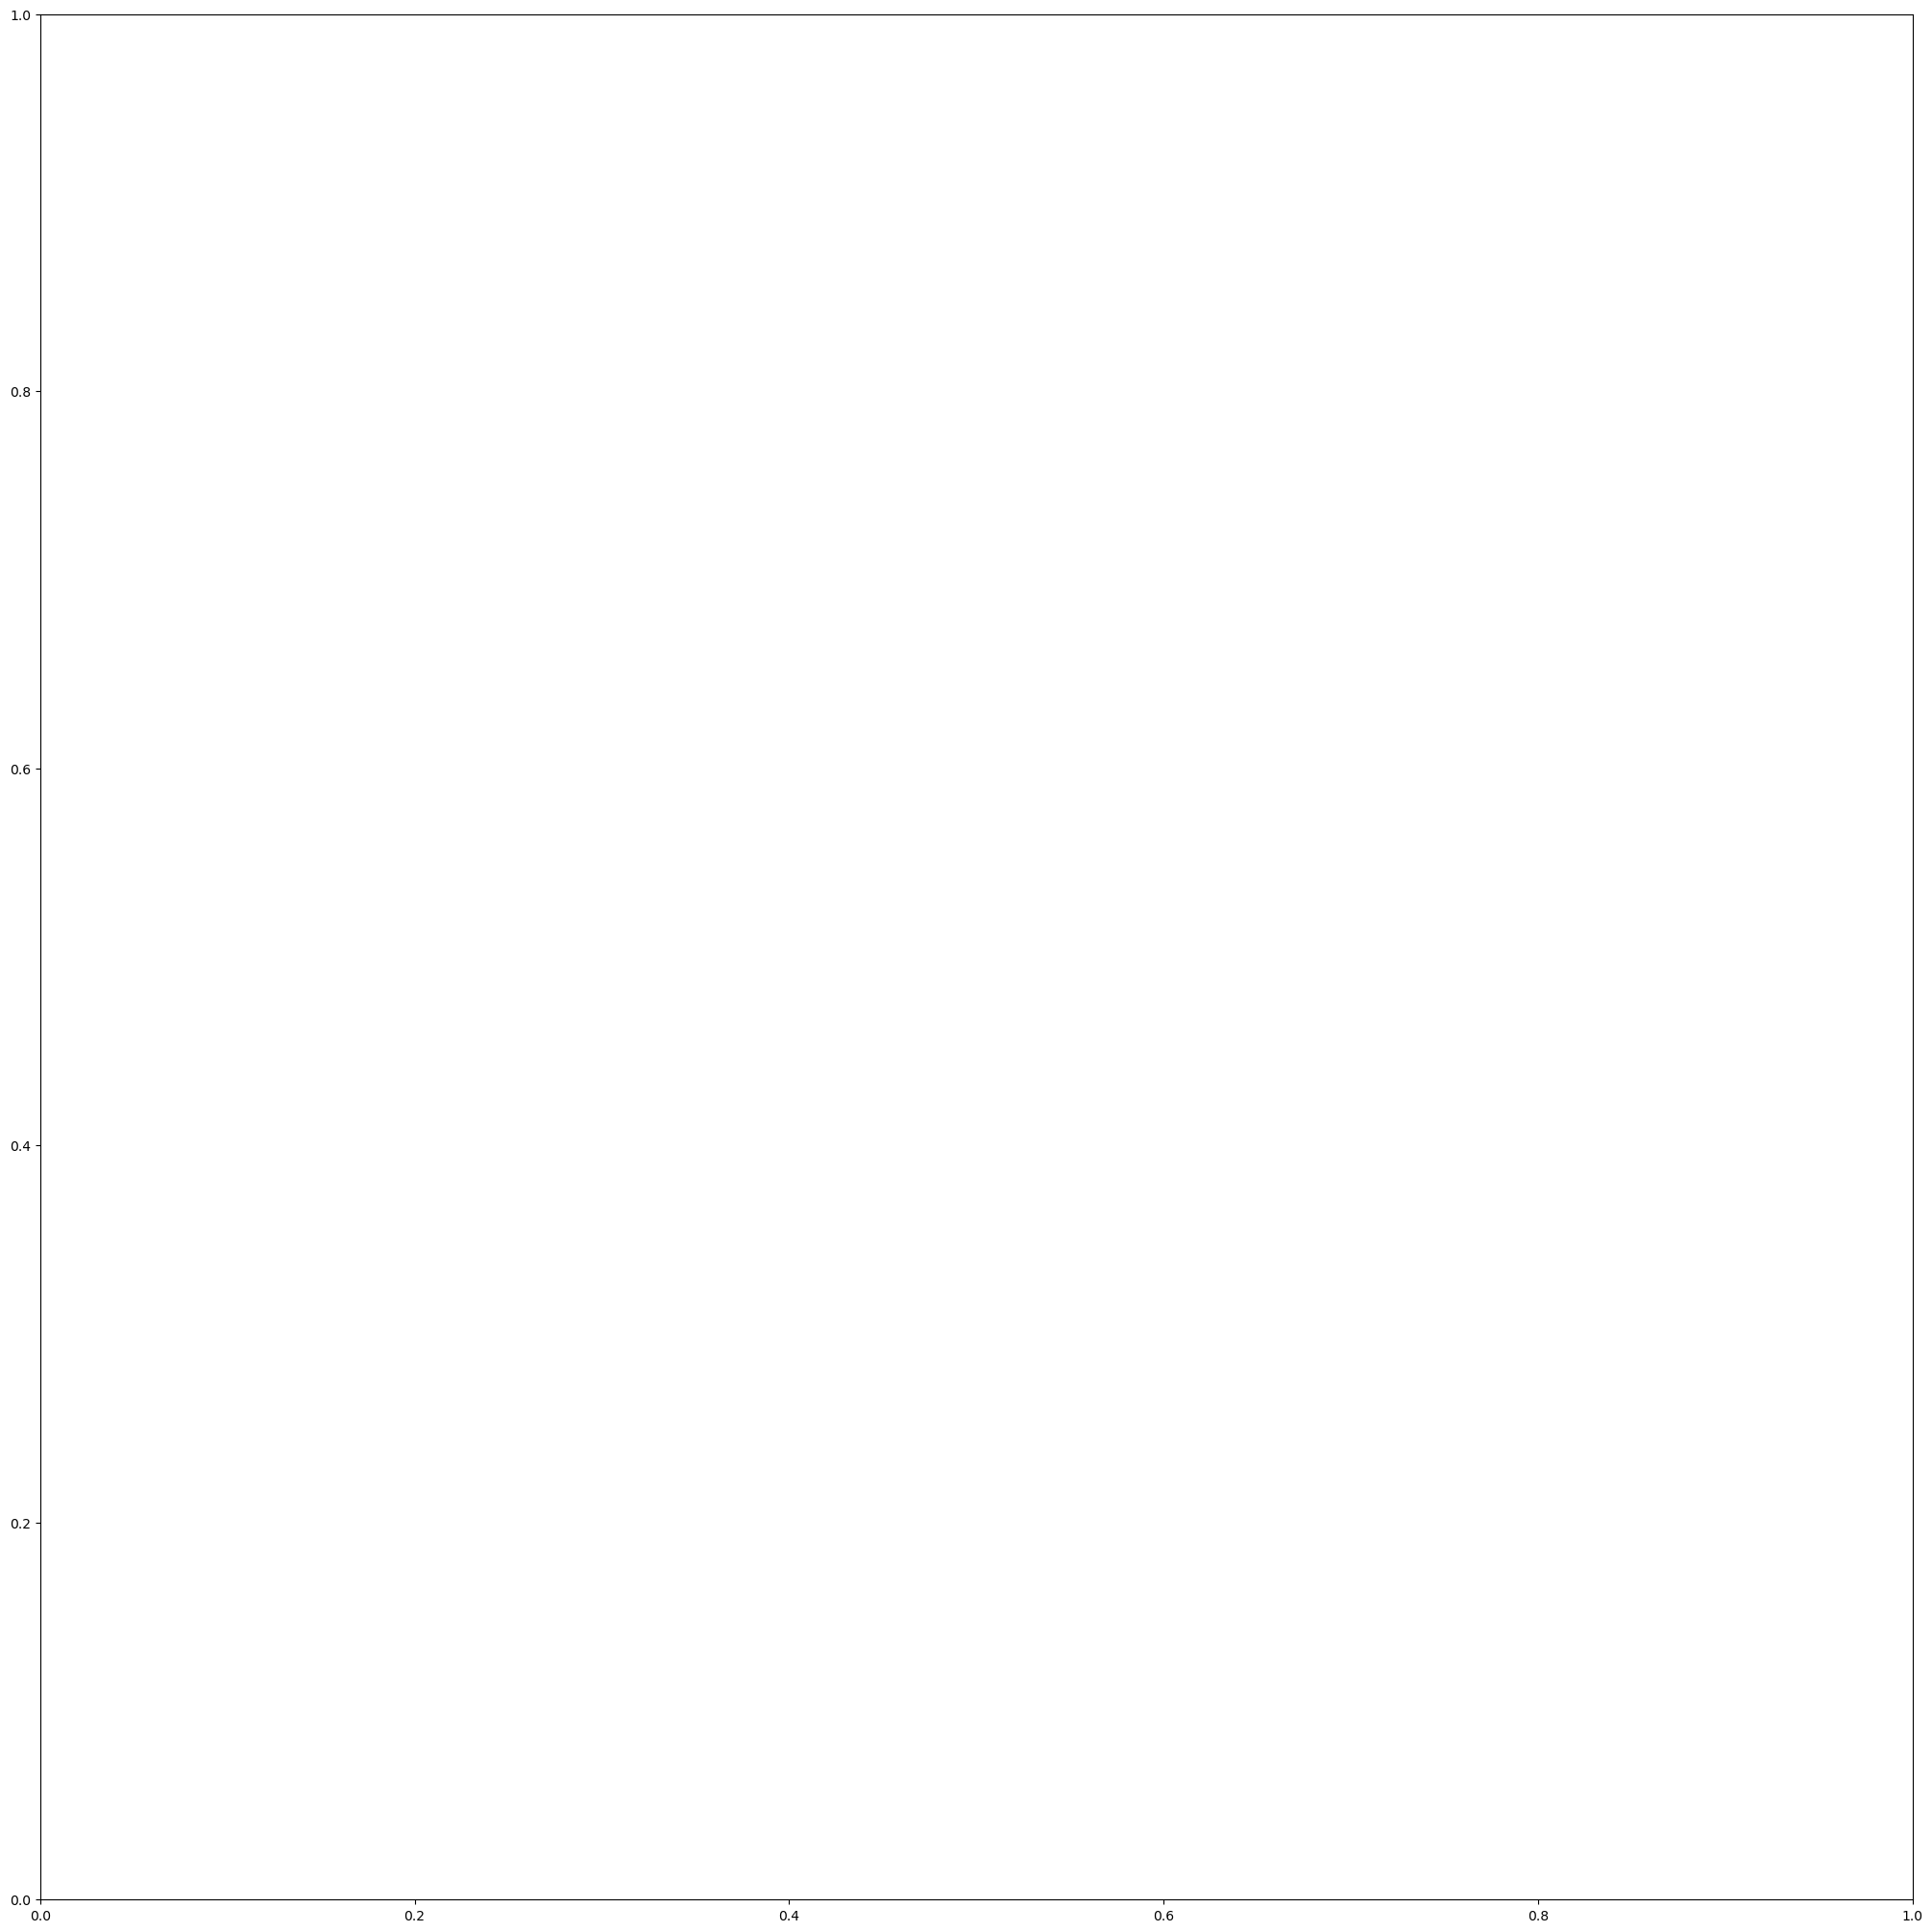

In [595]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')
legend_label = []

In [596]:
intersection_area = first_map.reset_index() & second_map.reset_index() & third_map.reset_index()

C:\Users\glebi\AppData\Local\Temp\ipykernel_23592\1311063145.py:1: FutureWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  intersection_area = first_map.reset_index() & second_map.reset_index() & third_map.reset_index()
C:\Users\glebi\AppData\Local\Temp\ipykernel_23592\1311063145.py:1: FutureWarning: '&' operator will be deprecated. Use the 'intersection' method instead.
  intersection_area = first_map.reset_index() & second_map.reset_index() & third_map.reset_index()


In [597]:
intersection_area

0    POLYGON ((-1483826.828 -1643642.051, -1483826....
dtype: geometry

In [598]:
intersection_area.area

0    5.332606e+11
dtype: float64

In [599]:
5.332606e+11/10**6

533260.6

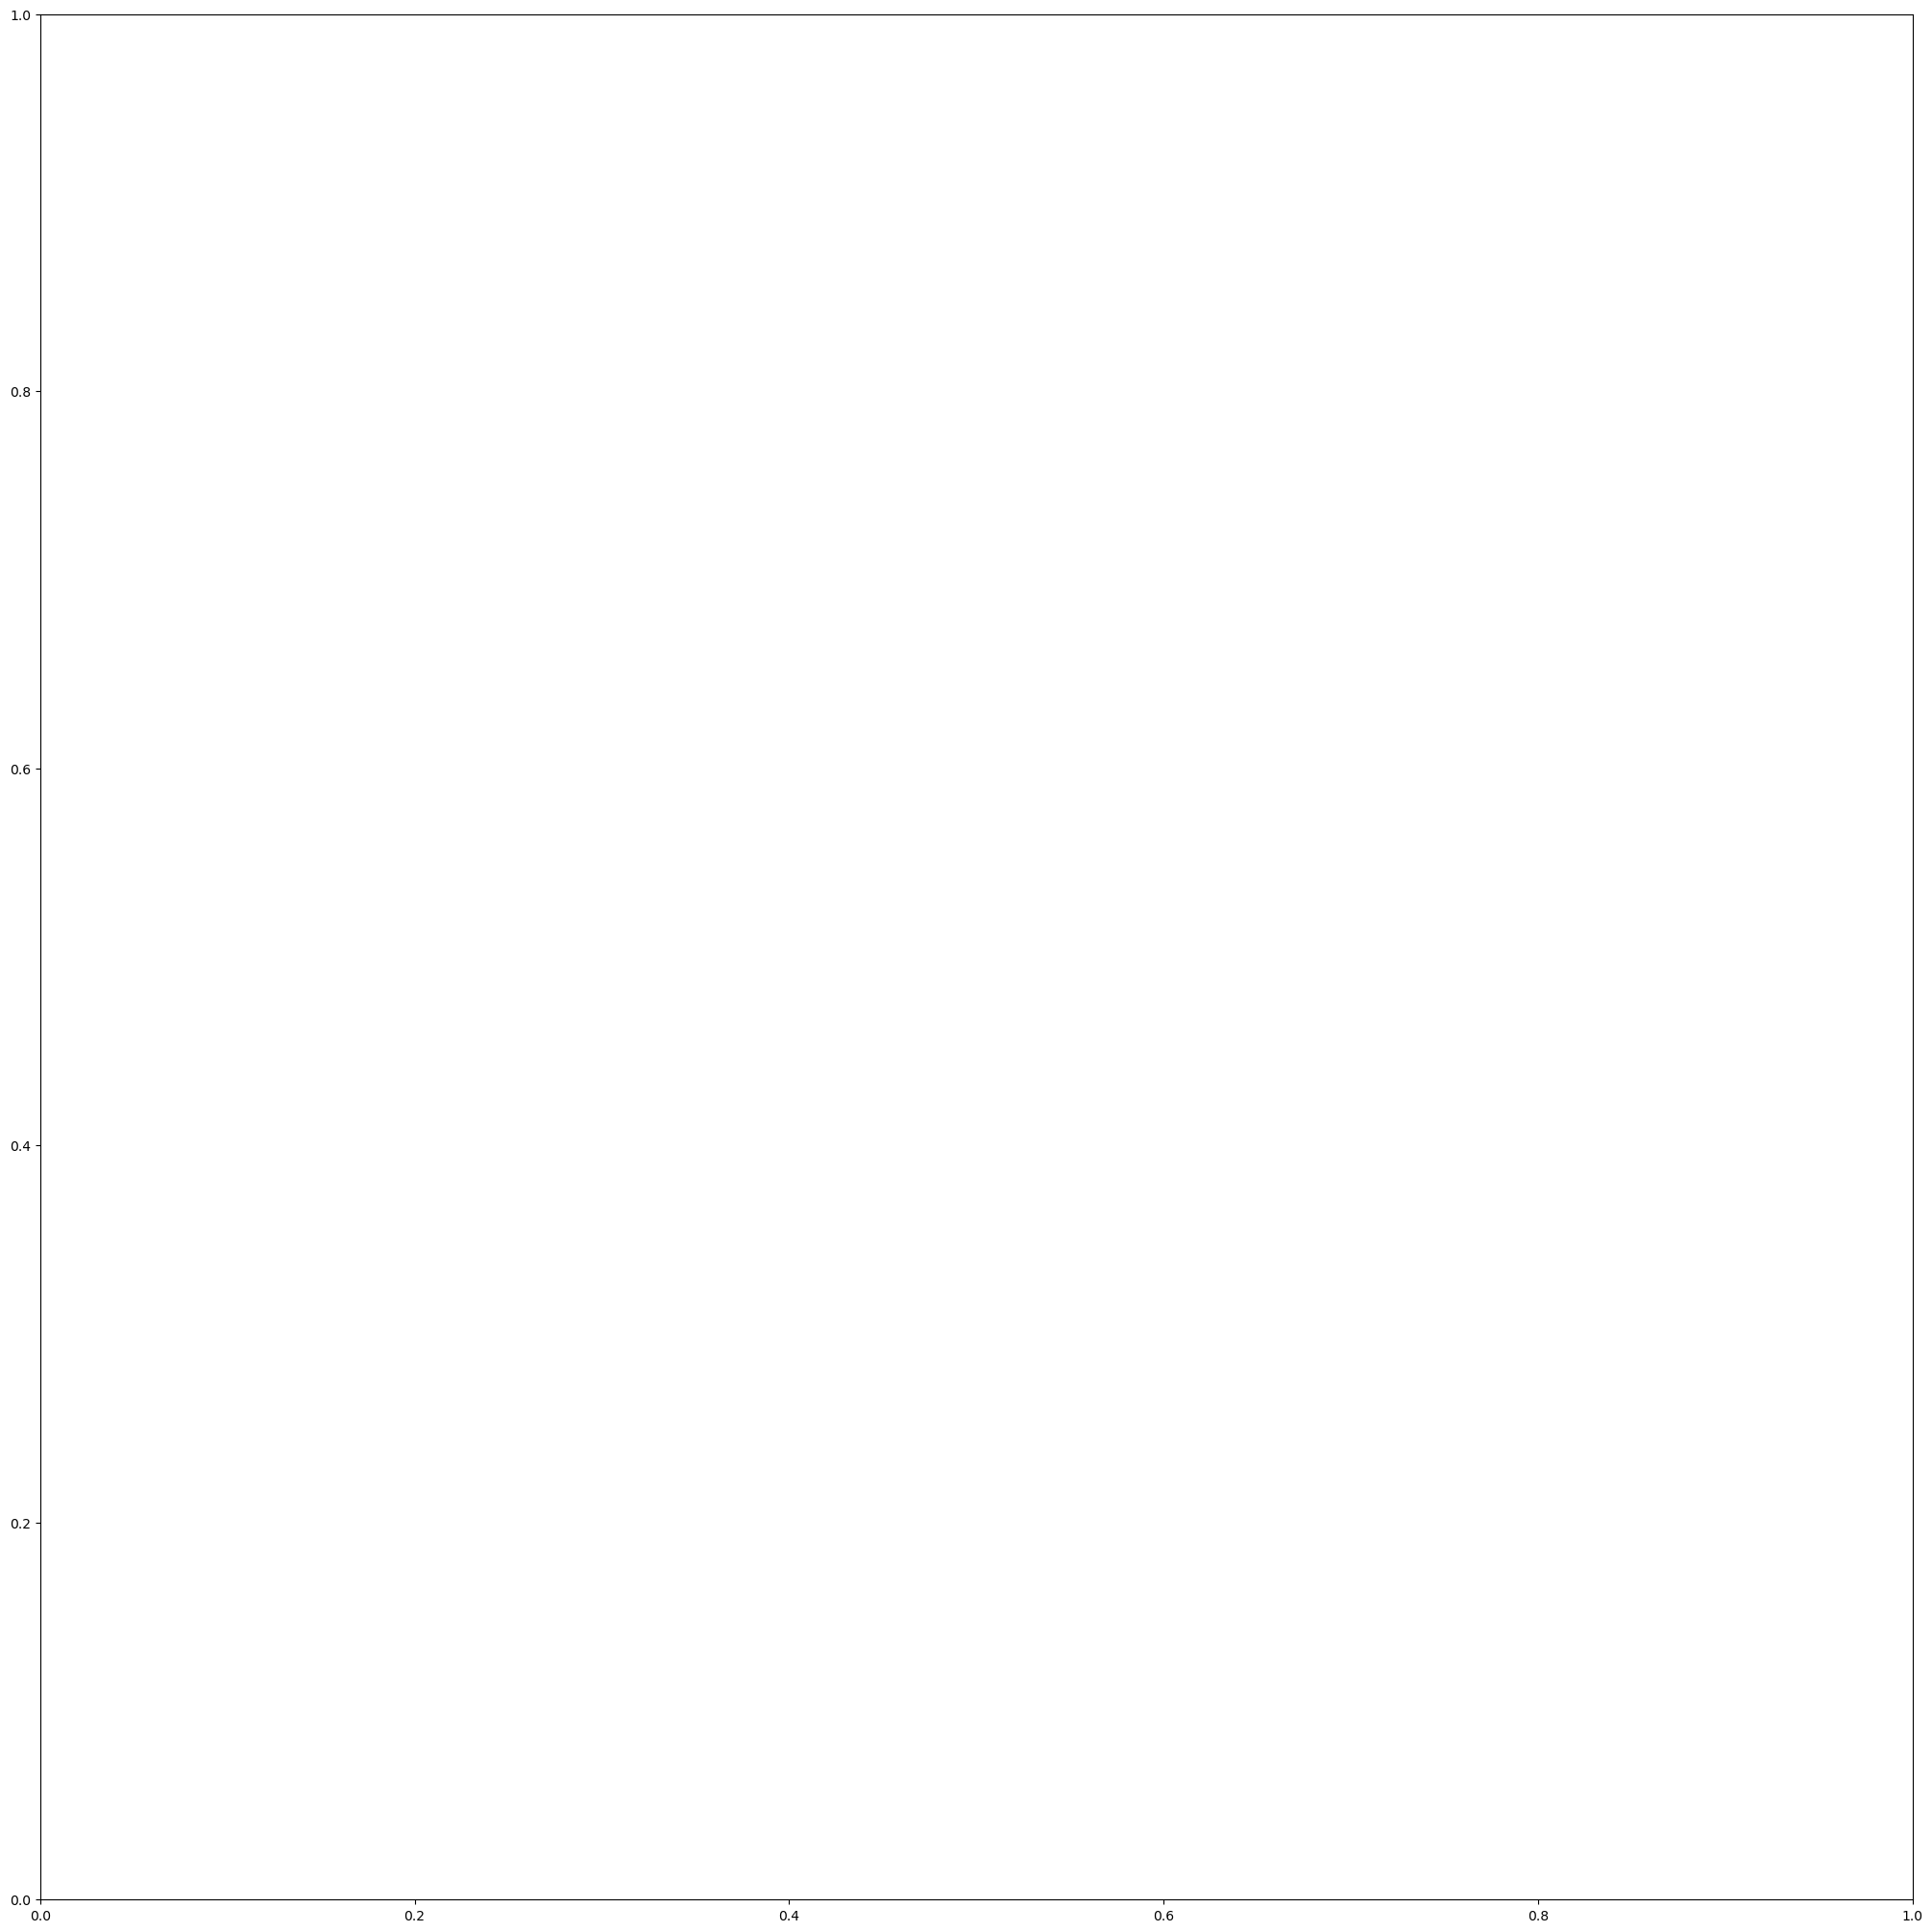

In [483]:
fig

In [484]:
tectonic.boundary.to_crs(crs).plot(edgecolor="black", facecolor=None, color=None, linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [485]:
land.to_crs(crs).plot(edgecolor="black", facecolor="wheat", linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [486]:
intersection_area.plot(
    alpha=0.5,
    color="lightskyblue",
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    label="Прогнозная область распространения верхнеюрских НГМТ",
)
legend_label.append(Patch(alpha=0.5, facecolor='lightskyblue', edgecolor='black', label=fill("Прогнозная область распространения верхнеюрских НГМТ", 20)))

<Figure size 640x480 with 0 Axes>

In [487]:
outcrops.to_crs(crs).plot(edgecolor="black", color="blue", linewidth=0.5, ax=ax);
legend_label.append(Patch(facecolor='blue', edgecolor='black', label=fill("Выходы юрских пород на поверхность", 20)))

<Figure size 640x480 with 0 Axes>

In [488]:
wells_older.to_crs(crs).plot(edgecolor="black", facecolor="black", linewidth=4, ax=ax)
legend_label.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="black",
        label=fill("Скважины, вскрывшие верхнеюрские отложения", 20),
        markerfacecolor="black",
        markersize=16,
        ls="",
    )
)

<Figure size 640x480 with 0 Axes>

In [489]:
# data_wells.to_crs(crs).plot(edgecolor="black", facecolor="red", linewidth=2, ax=ax);
# for row in data_wells.to_crs(crs).iterrows():
#     x, y = row["geometry"].geometry.xy
#     label = row["HIo"]
#     ax.annotate(label, xy=(x, y), xytext=(10, 10), textcoords="offset points")

# legend_label.append(
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="red",
#         label=fill("Значения по скважинам, средние", 20),
#         markerfacecolor="black",
#         markersize=16,
#         ls="",
#     )
# )

In [490]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

In [491]:
ax.tick_params(axis='both', labelsize=14)

In [492]:
ax.legend(
    handles=legend_label,
    title="Условные обозначения",
    fontsize=16,
    title_fontsize=20,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.0,
    frameon=False,
    handleheight=2, handlelength=3
)

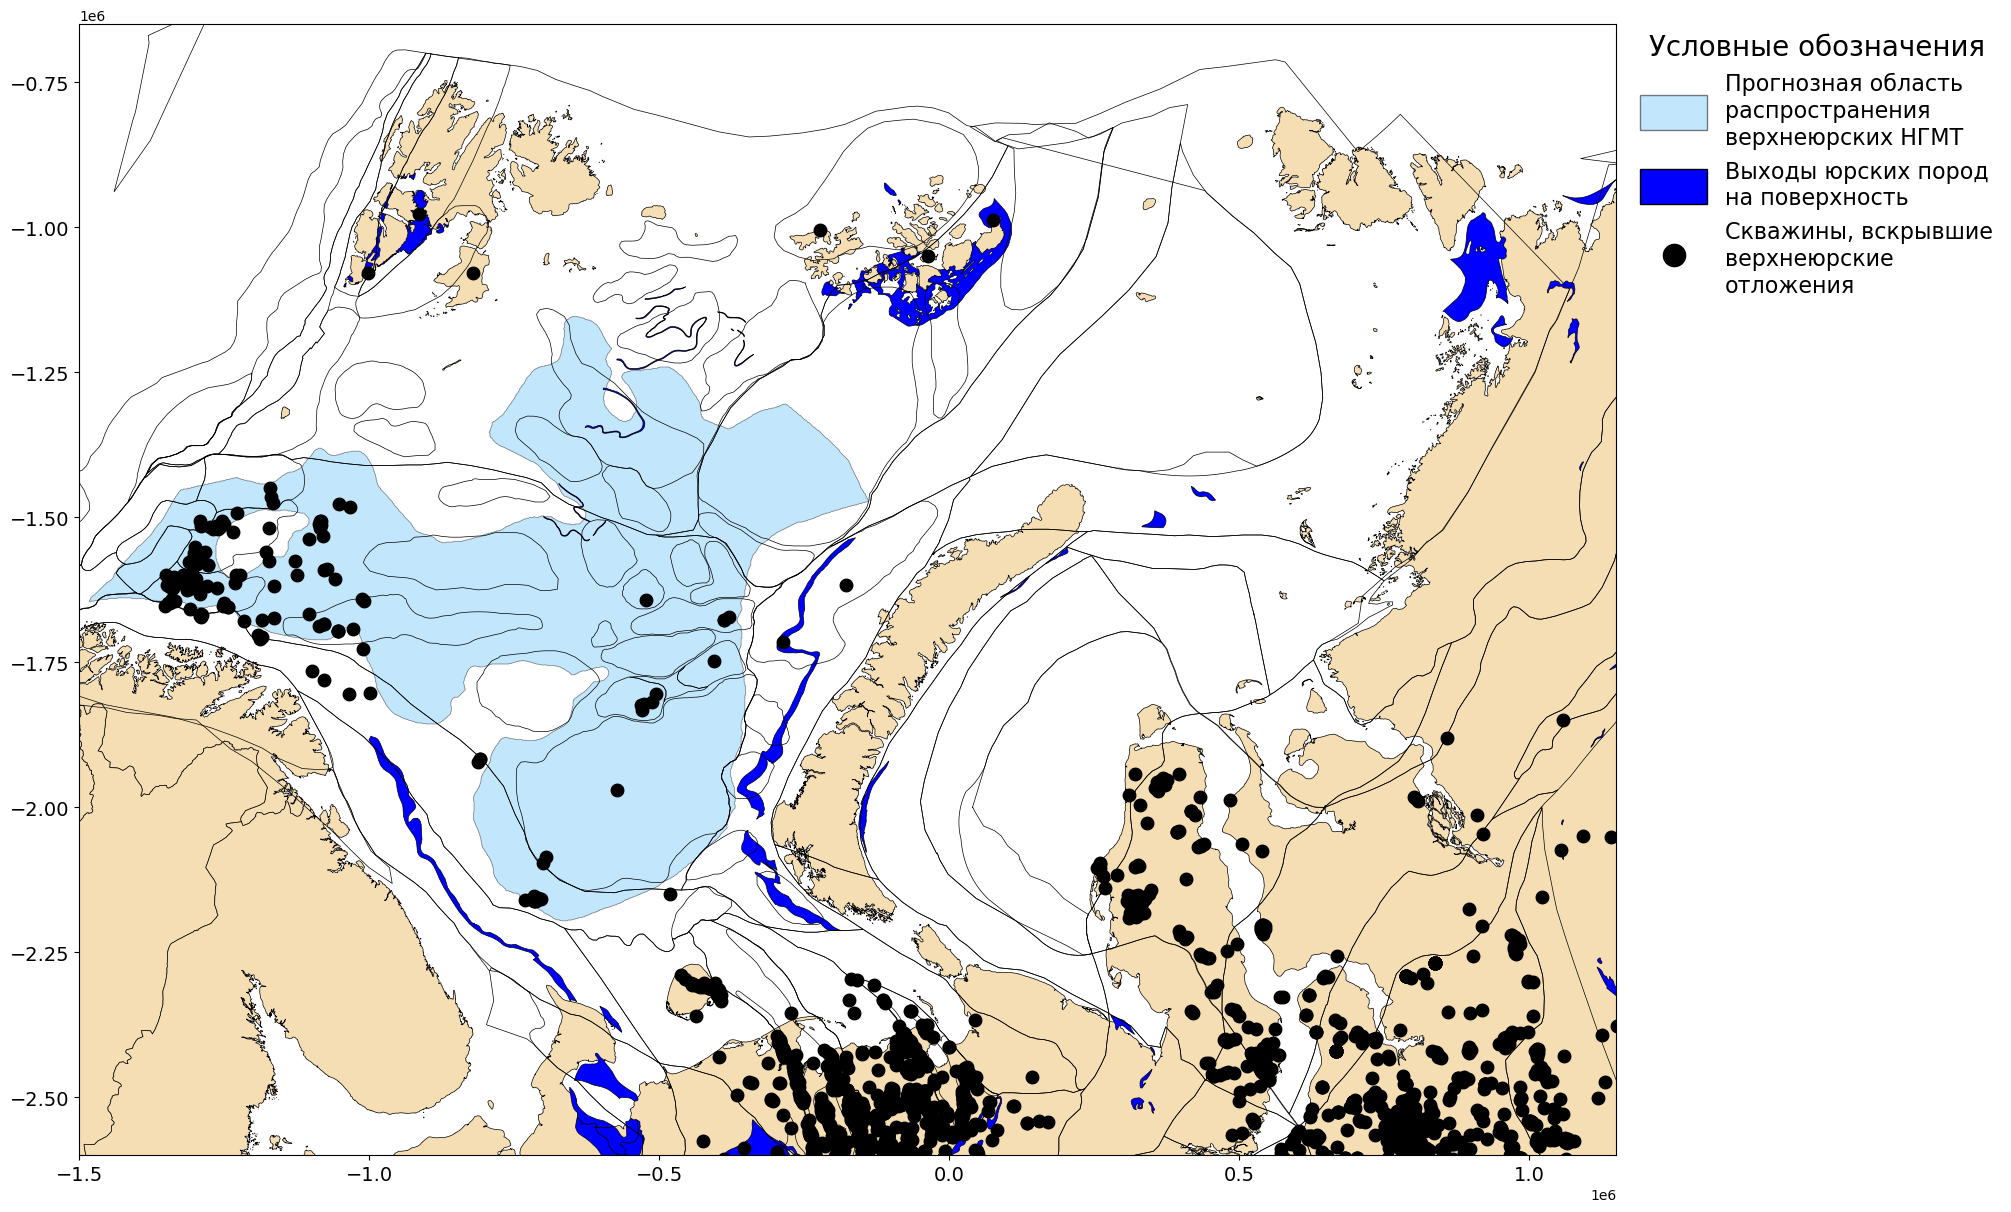

In [493]:
fig

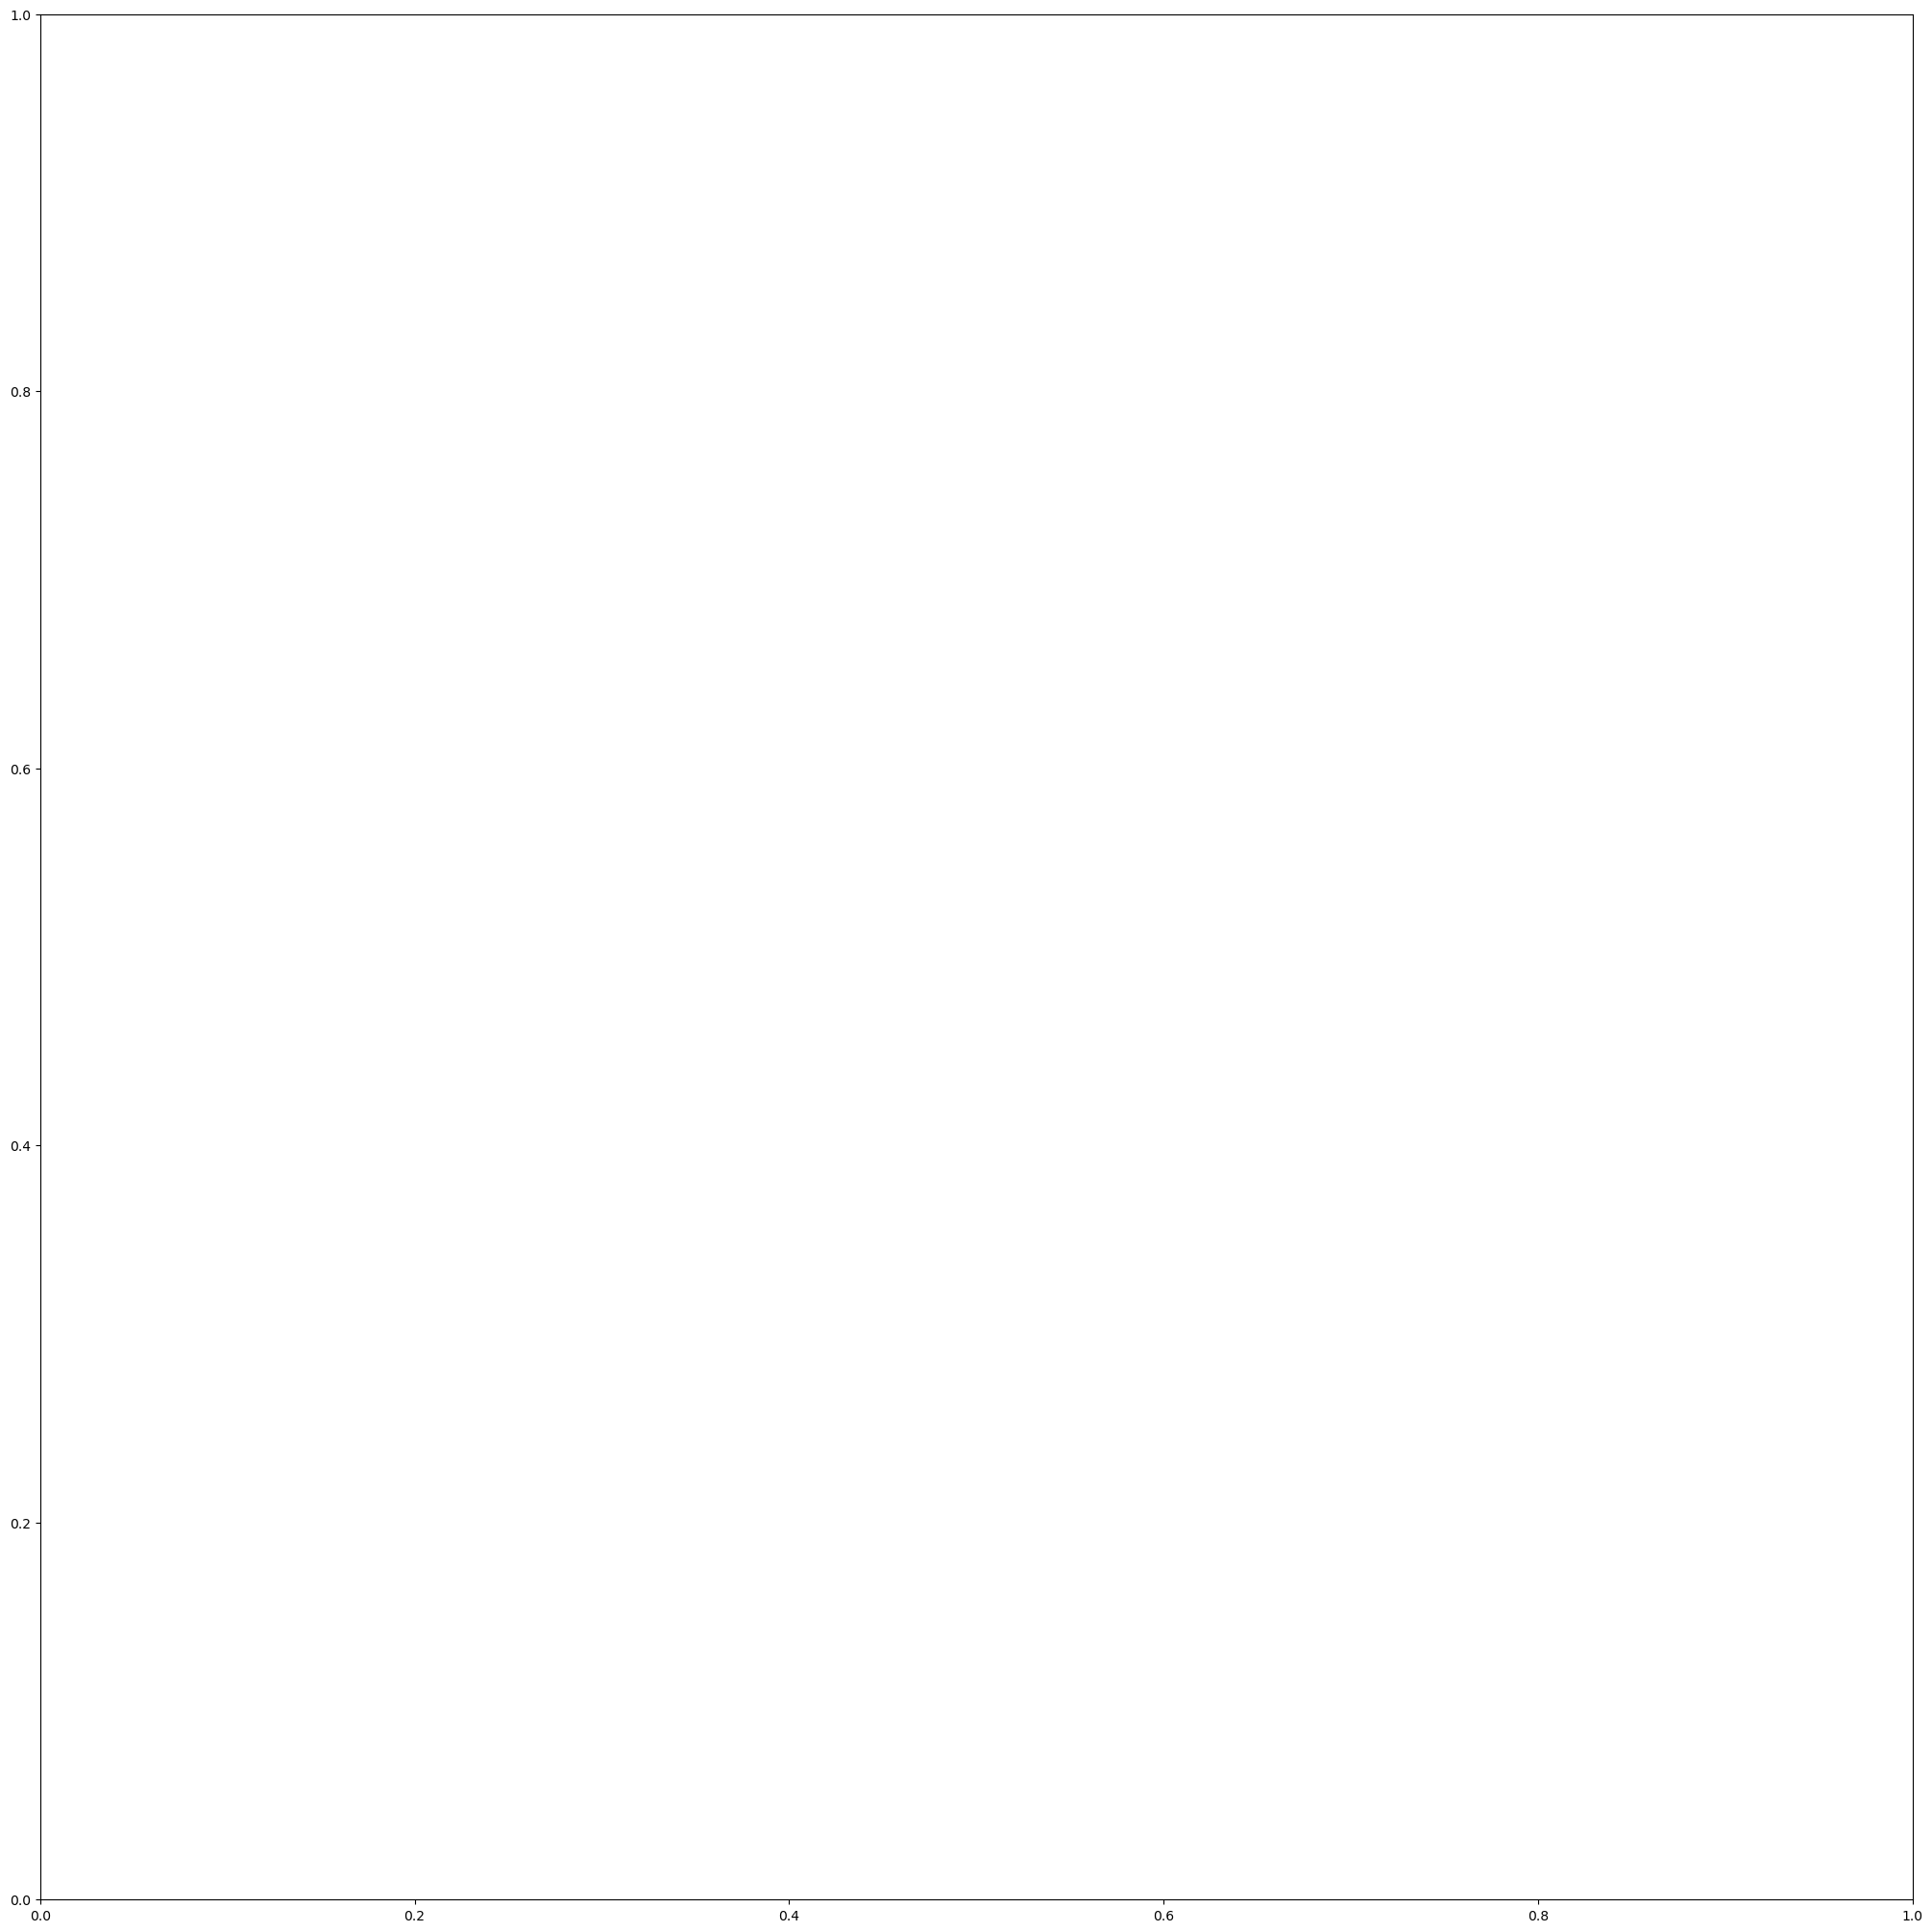

In [465]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')
legend_label = []

In [600]:
union_area = first_map.reset_index() | second_map.reset_index() | third_map.reset_index()

C:\Users\glebi\AppData\Local\Temp\ipykernel_23592\3514030854.py:1: FutureWarning: '|' operator will be deprecated. Use the 'union' method instead.
  union_area = first_map.reset_index() | second_map.reset_index() | third_map.reset_index()
C:\Users\glebi\AppData\Local\Temp\ipykernel_23592\3514030854.py:1: FutureWarning: '|' operator will be deprecated. Use the 'union' method instead.
  union_area = first_map.reset_index() | second_map.reset_index() | third_map.reset_index()


In [601]:
union_area

0    POLYGON ((93423.272 -1694891.713, 94579.143 -1...
dtype: geometry

In [603]:
union_area.area / 10**6

0    1.781339e+06
dtype: float64

In [604]:
1.781339e+06

1781339.0

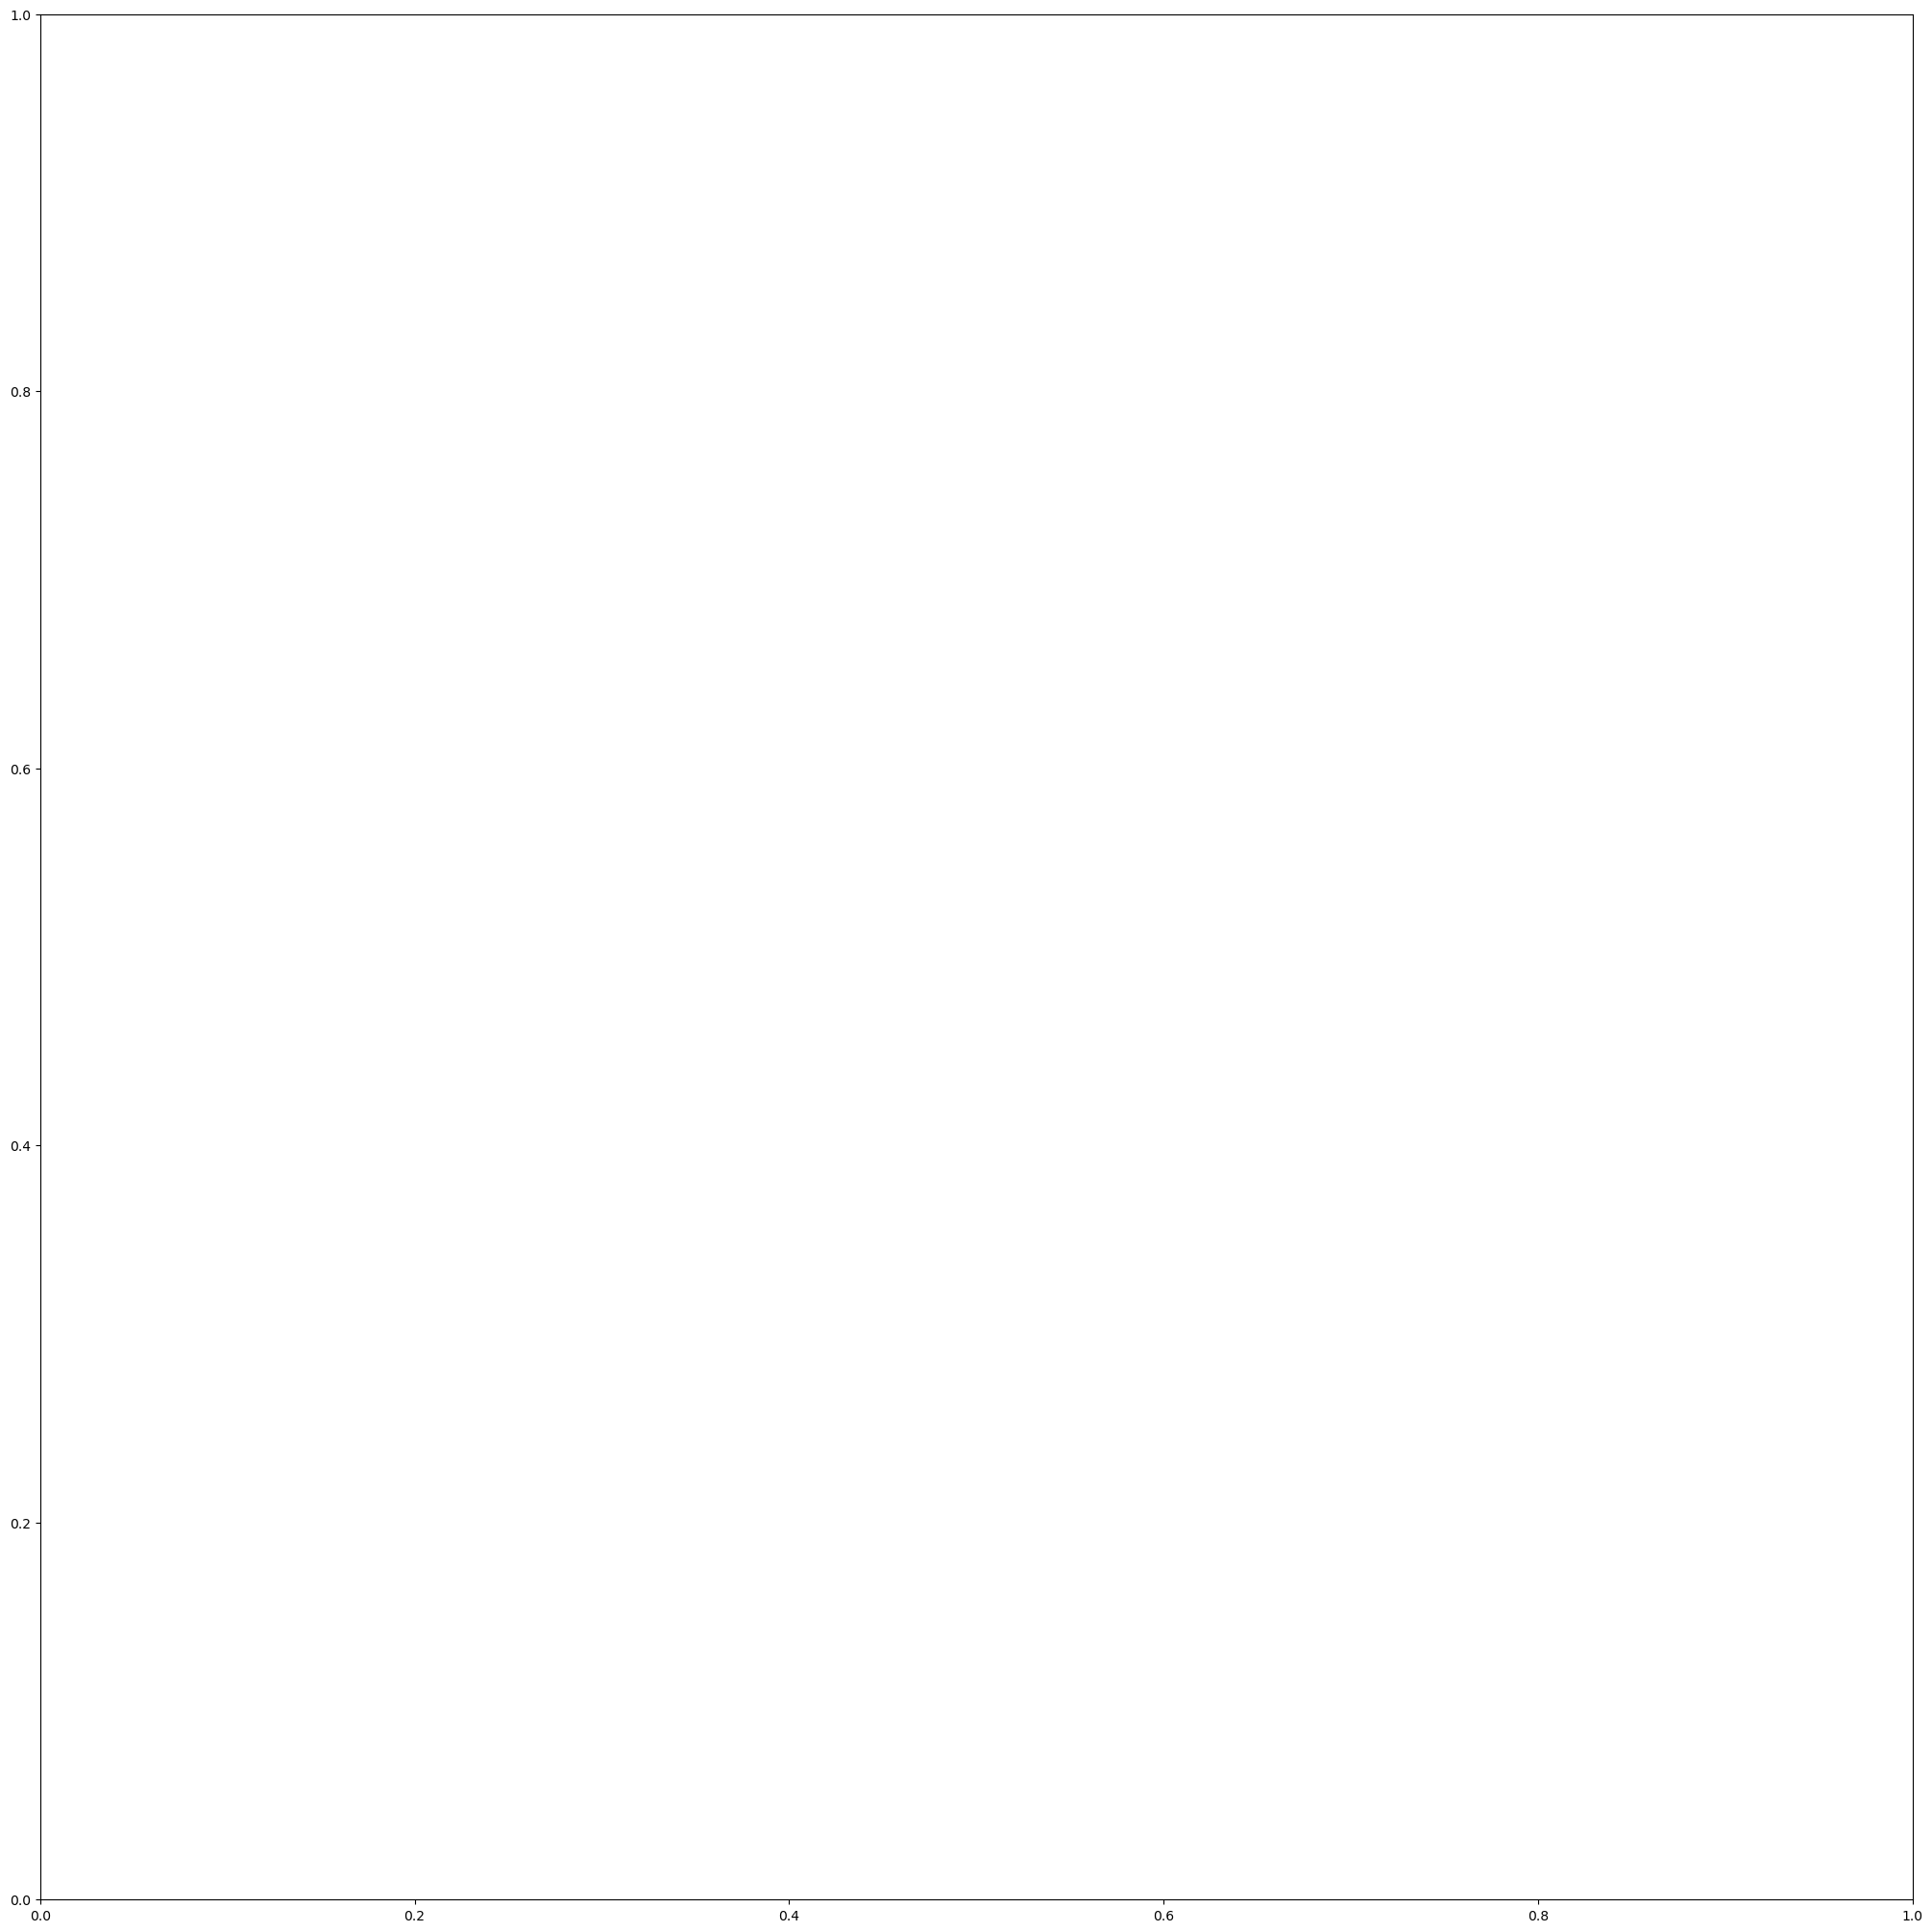

In [468]:
fig

In [469]:
tectonic.boundary.to_crs(crs).plot(edgecolor="black", facecolor=None, color=None, linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [470]:
land.to_crs(crs).plot(edgecolor="black", facecolor="wheat", linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [471]:
union_area.plot(
    alpha=0.5,
    color="lightskyblue",
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
    label="Прогнозная область распространения верхнеюрских НГМТ",
)
legend_label.append(Patch(alpha=0.5, facecolor='lightskyblue', edgecolor='black', label=fill("Прогнозная область распространения верхнеюрских НГМТ", 20)))

<Figure size 640x480 with 0 Axes>

In [472]:
outcrops.to_crs(crs).plot(edgecolor="black", color="blue", linewidth=0.5, ax=ax);
legend_label.append(Patch(facecolor='blue', edgecolor='black', label=fill("Выходы юрских пород на поверхность", 20)))

<Figure size 640x480 with 0 Axes>

In [473]:
wells_older.to_crs(crs).plot(edgecolor="black", facecolor="black", linewidth=4, ax=ax)
legend_label.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="black",
        label=fill("Скважины, вскрывшие верхнеюрские отложения", 20),
        markerfacecolor="black",
        markersize=16,
        ls="",
    )
)

<Figure size 640x480 with 0 Axes>

In [474]:
# data_wells.to_crs(crs).plot(edgecolor="black", facecolor="red", linewidth=2, ax=ax);
# for row in data_wells.to_crs(crs).iterrows():
#     x, y = row["geometry"].geometry.xy
#     label = row["HIo"]
#     ax.annotate(label, xy=(x, y), xytext=(10, 10), textcoords="offset points")

# legend_label.append(
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="red",
#         label=fill("Значения по скважинам, средние", 20),
#         markerfacecolor="black",
#         markersize=16,
#         ls="",
#     )
# )

In [475]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

In [476]:
ax.tick_params(axis='both', labelsize=14)

In [477]:
ax.legend(
    handles=legend_label,
    title="Условные обозначения",
    fontsize=16,
    title_fontsize=20,
    bbox_to_anchor=(1.01, 1),
    loc="upper left",
    borderaxespad=0.0,
    frameon=False,
    handleheight=2, handlelength=3
)

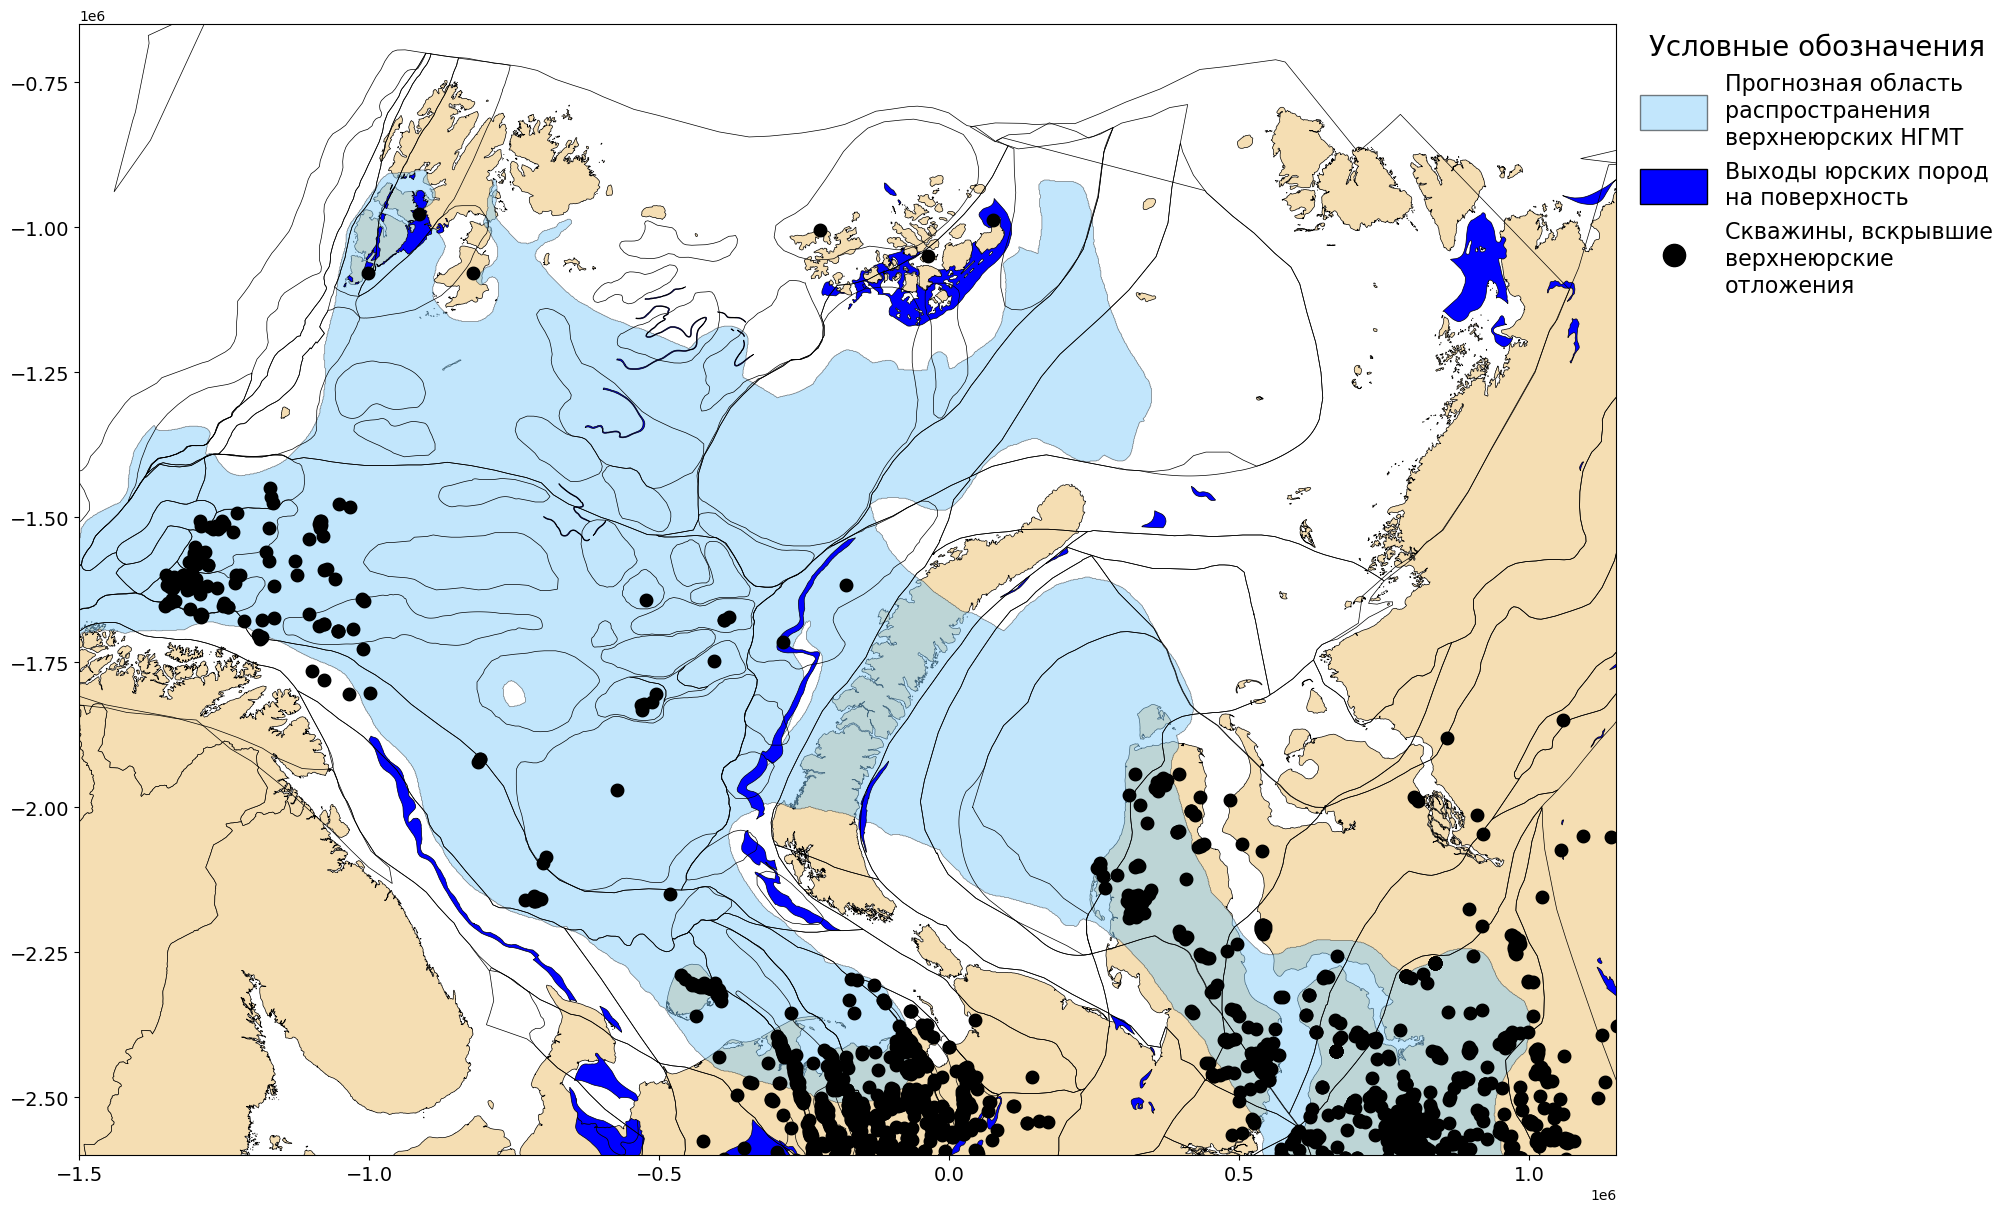

In [478]:
fig

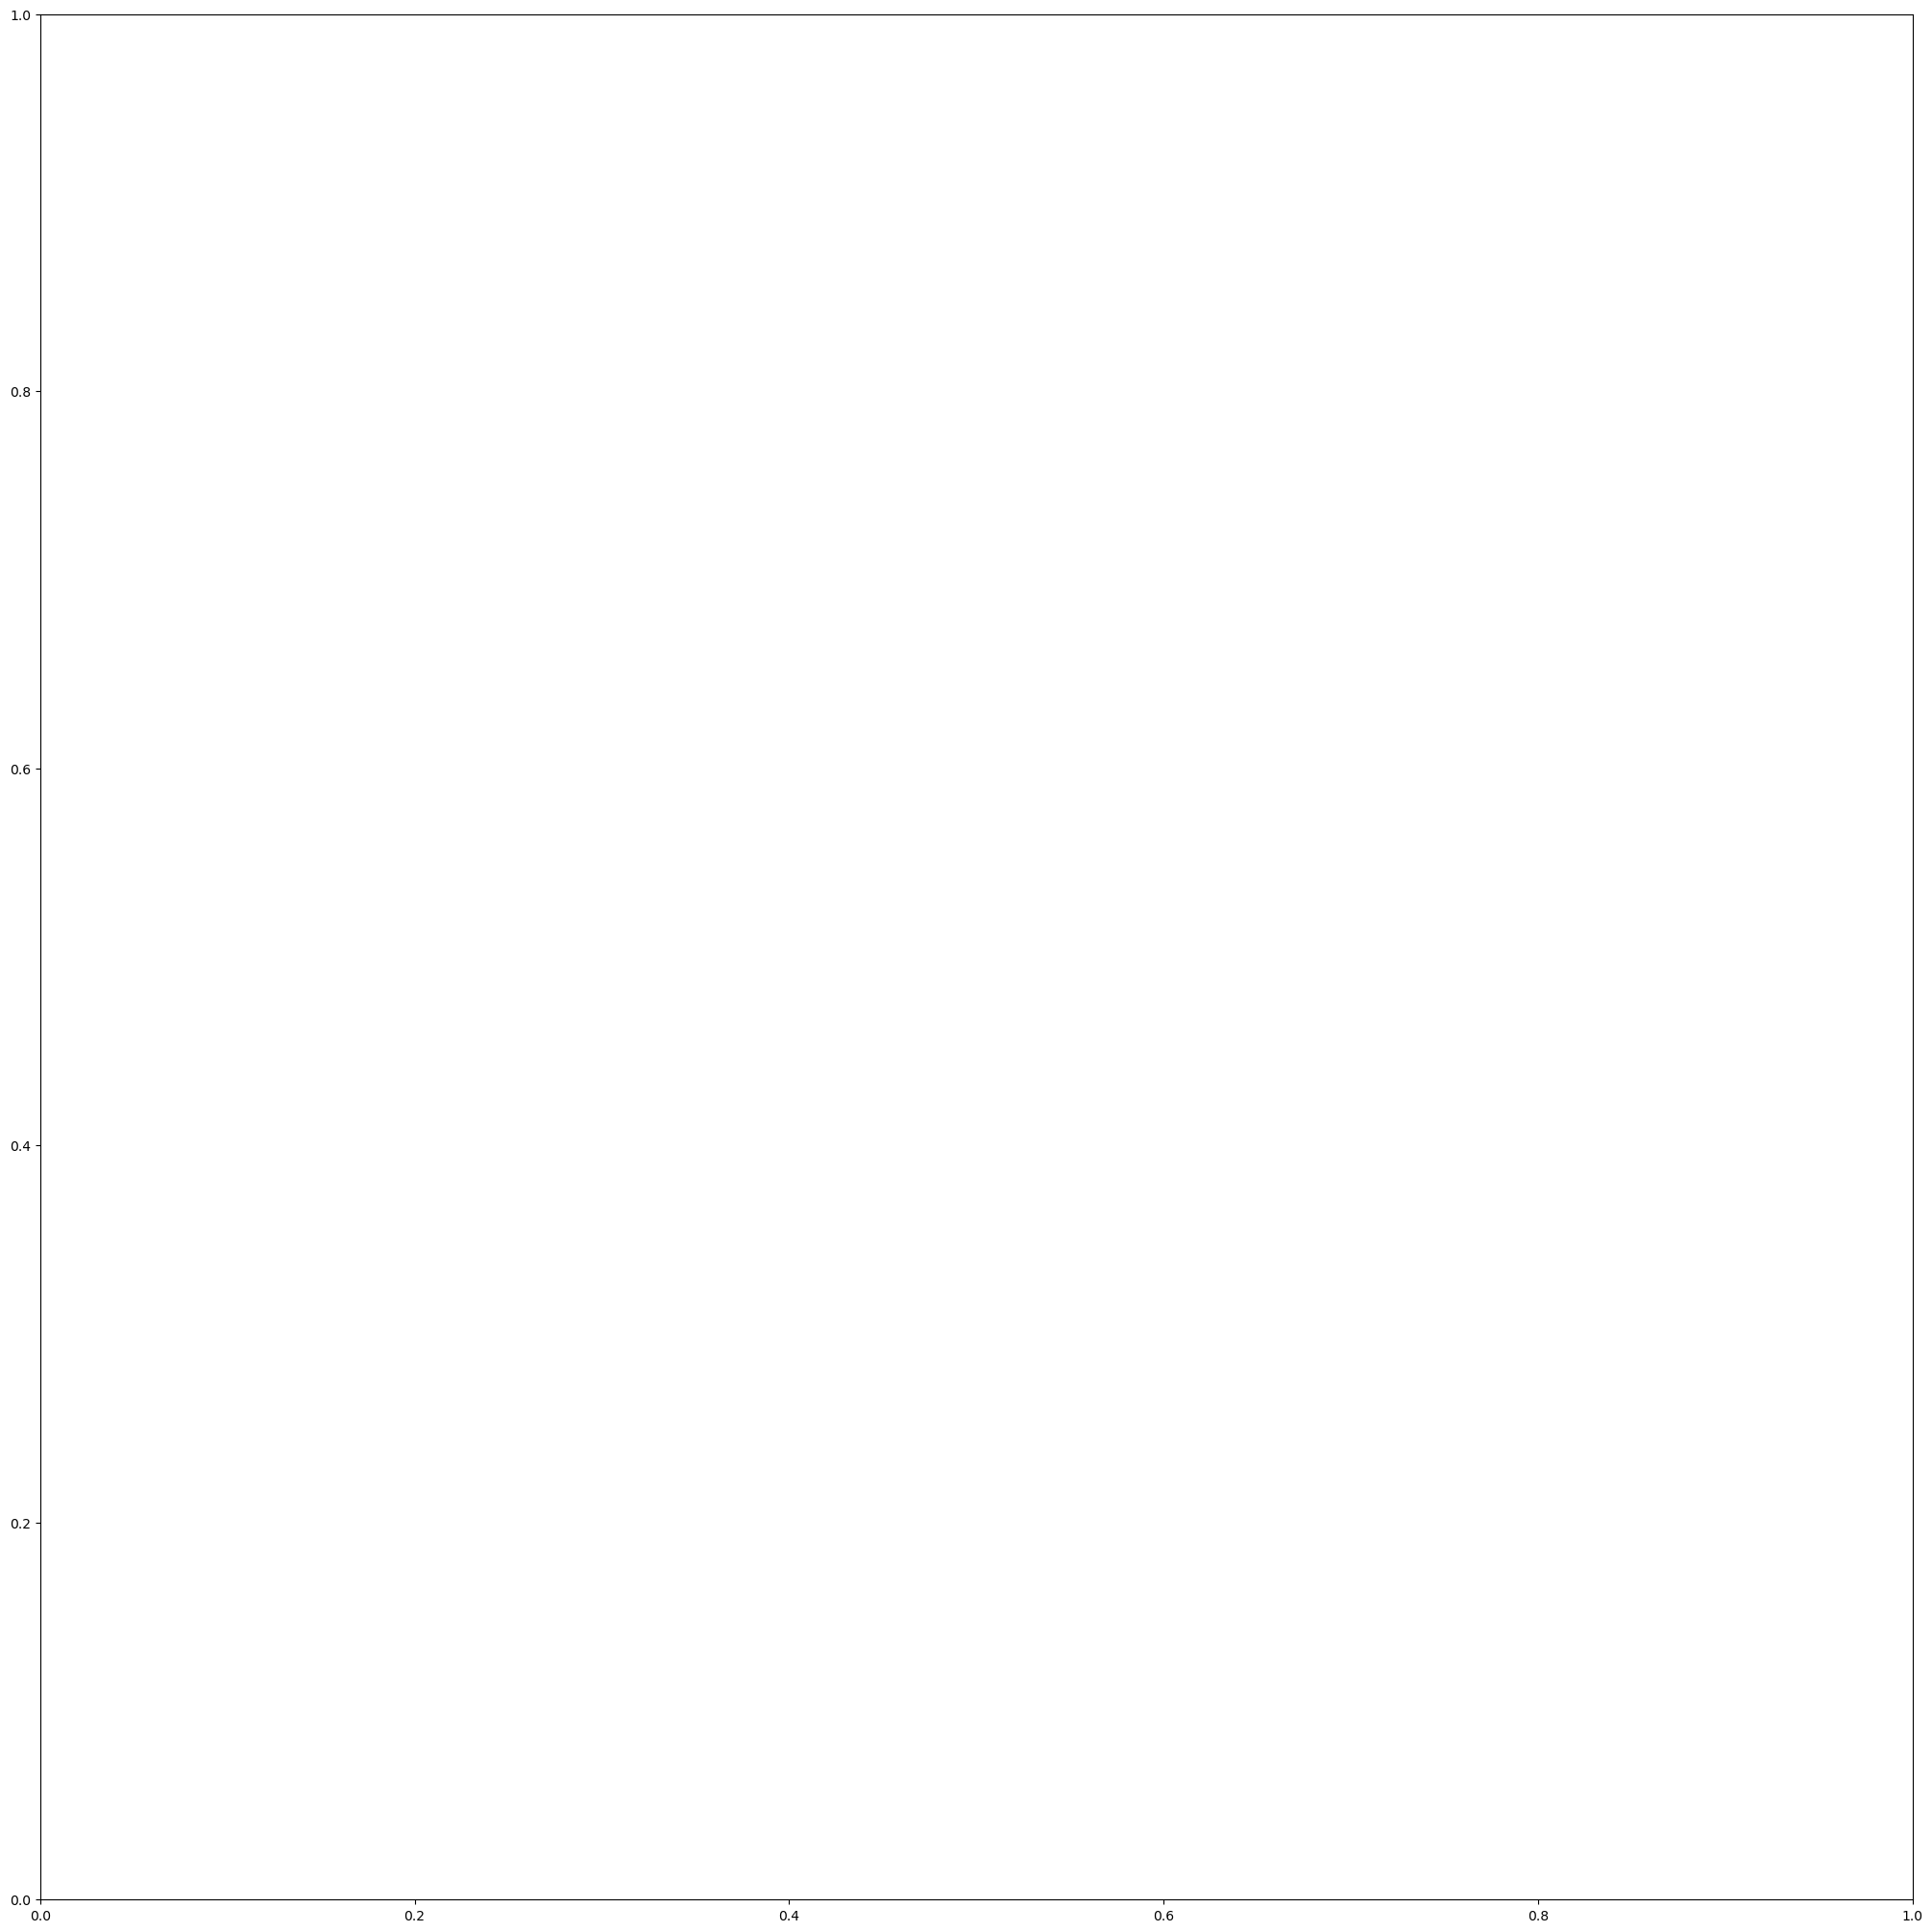

In [479]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')

In [286]:
tectonic_sib = gpd.read_file("../Карты/Тектоническое строение/Структуры_Сибирь.shp").rename(columns={"name_rus": "Name Russian", "Name_eng": "Name English"})
tectonic_smng = gpd.read_file("../Карты/Тектоническое строение/Структуры_СМНГ.shp").rename(columns={"Name_rus": "Name Russian", "Name":"Name English"})
tectonic = pd.concat([tectonic_sib, tectonic_smng]).loc[:, ["Name Russian", "Name English", "geometry"]]

In [287]:
tectonic.boundary.to_crs(crs).plot(edgecolor="black", facecolor=None, color=None, linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [288]:
tectonic

Name Russian                           Name English  \
0    Казахстанская складчатая област                       Kazahstan upland   
1   Средне-Уральская моноклиналь (ге                  Middle Ural monocline   
2    Среднеобская система сводовых п  West Siberia continental rifting zone   
3                      Полярный Урал                             Polar Ural   
4       Предуральский краевой прогиб                          Ural foreland   
..                               ...                                    ...   
51               поднятие Бъярмелэнд                     Bjarmeland plaform   
52        Северо-Баренцевская депрес               North-Barents depression   
53               Земля Франса Иосифа                       Franz Josef high   
54        Альбановского-Горбовский п            Albanovsko-Gorbovsky saddle   
55                Прогиб Святой Анны                        St. Anna trough   

                                             geometry  
0   POLYGON ((-1153922.866 2539707.573, -1175152.6...  
1   POLYGON ((-1570061.564 3570935.581, -1555494.1...  
2   POLYGON ((-1199833.170 3912807.752, -1162921.1...  
3   POLYGON ((-1125669.610 4326595.404, -1127192.0...  
4   POLYGON ((-1965342.854 3834917.992, -1957381.2...  
..                                                ...  
51  POLYGON ((-2242748.876 5666220.353, -2251812.0...  
52  POLYGON ((-1298552.206 5822450.291, -1296926.6...  
53  POLYGON ((-1385472.028 6021895.342, -1378418.1...  
54  POLYGON ((-1045308.344 5783567.673, -1040446.6...  
55  POLYGON ((-735312.243 5883654.634, -716427.472...  

[124 rows x 3 columns]

In [289]:
tectonic['Name Russian'] = tectonic['Name Russian'].str.wrap(15)

In [290]:
tectonic['Name Russian']

0       Казахстанская\nскладчатая\nобласт
1     Средне-\nУральская\nмоноклиналь (ге
2       Среднеобская\nсистема\nсводовых п
3                           Полярный Урал
4           Предуральский\nкраевой прогиб
                     ...                 
51                   поднятие\nБъярмелэнд
52          Северо-\nБаренцевская\nдепрес
53                   Земля Франса\nИосифа
54           Альбановского-\nГорбовский п
55                    Прогиб Святой\nАнны
Name: Name Russian, Length: 124, dtype: object

In [291]:
tectonic.dropna().to_crs(crs).apply(lambda x: ax.annotate(text=x['Name Russian'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

0     Annotation(675210, -4.18484e+06, 'Казахстанска...
1     Annotation(235024, -3.80915e+06, 'Средне-\nУра...
2     Annotation(955021, -3.44938e+06, 'Среднеобская...
3     Annotation(78857.6, -2.9003e+06, 'Полярный Урал')
4     Annotation(-42809.9, -2.83197e+06, 'Предуральс...
                            ...                        
51    Annotation(-832863, -1.57715e+06, 'поднятие\nБ...
52    Annotation(-224096, -1.34414e+06, 'Северо-\nБа...
53    Annotation(-110560, -939325, 'Земля Франса\nИо...
54    Annotation(-5511.41, -1.20223e+06, 'Альбановск...
55    Annotation(172589, -969383, 'Прогиб Святой\nАн...
Length: 120, dtype: object

In [292]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

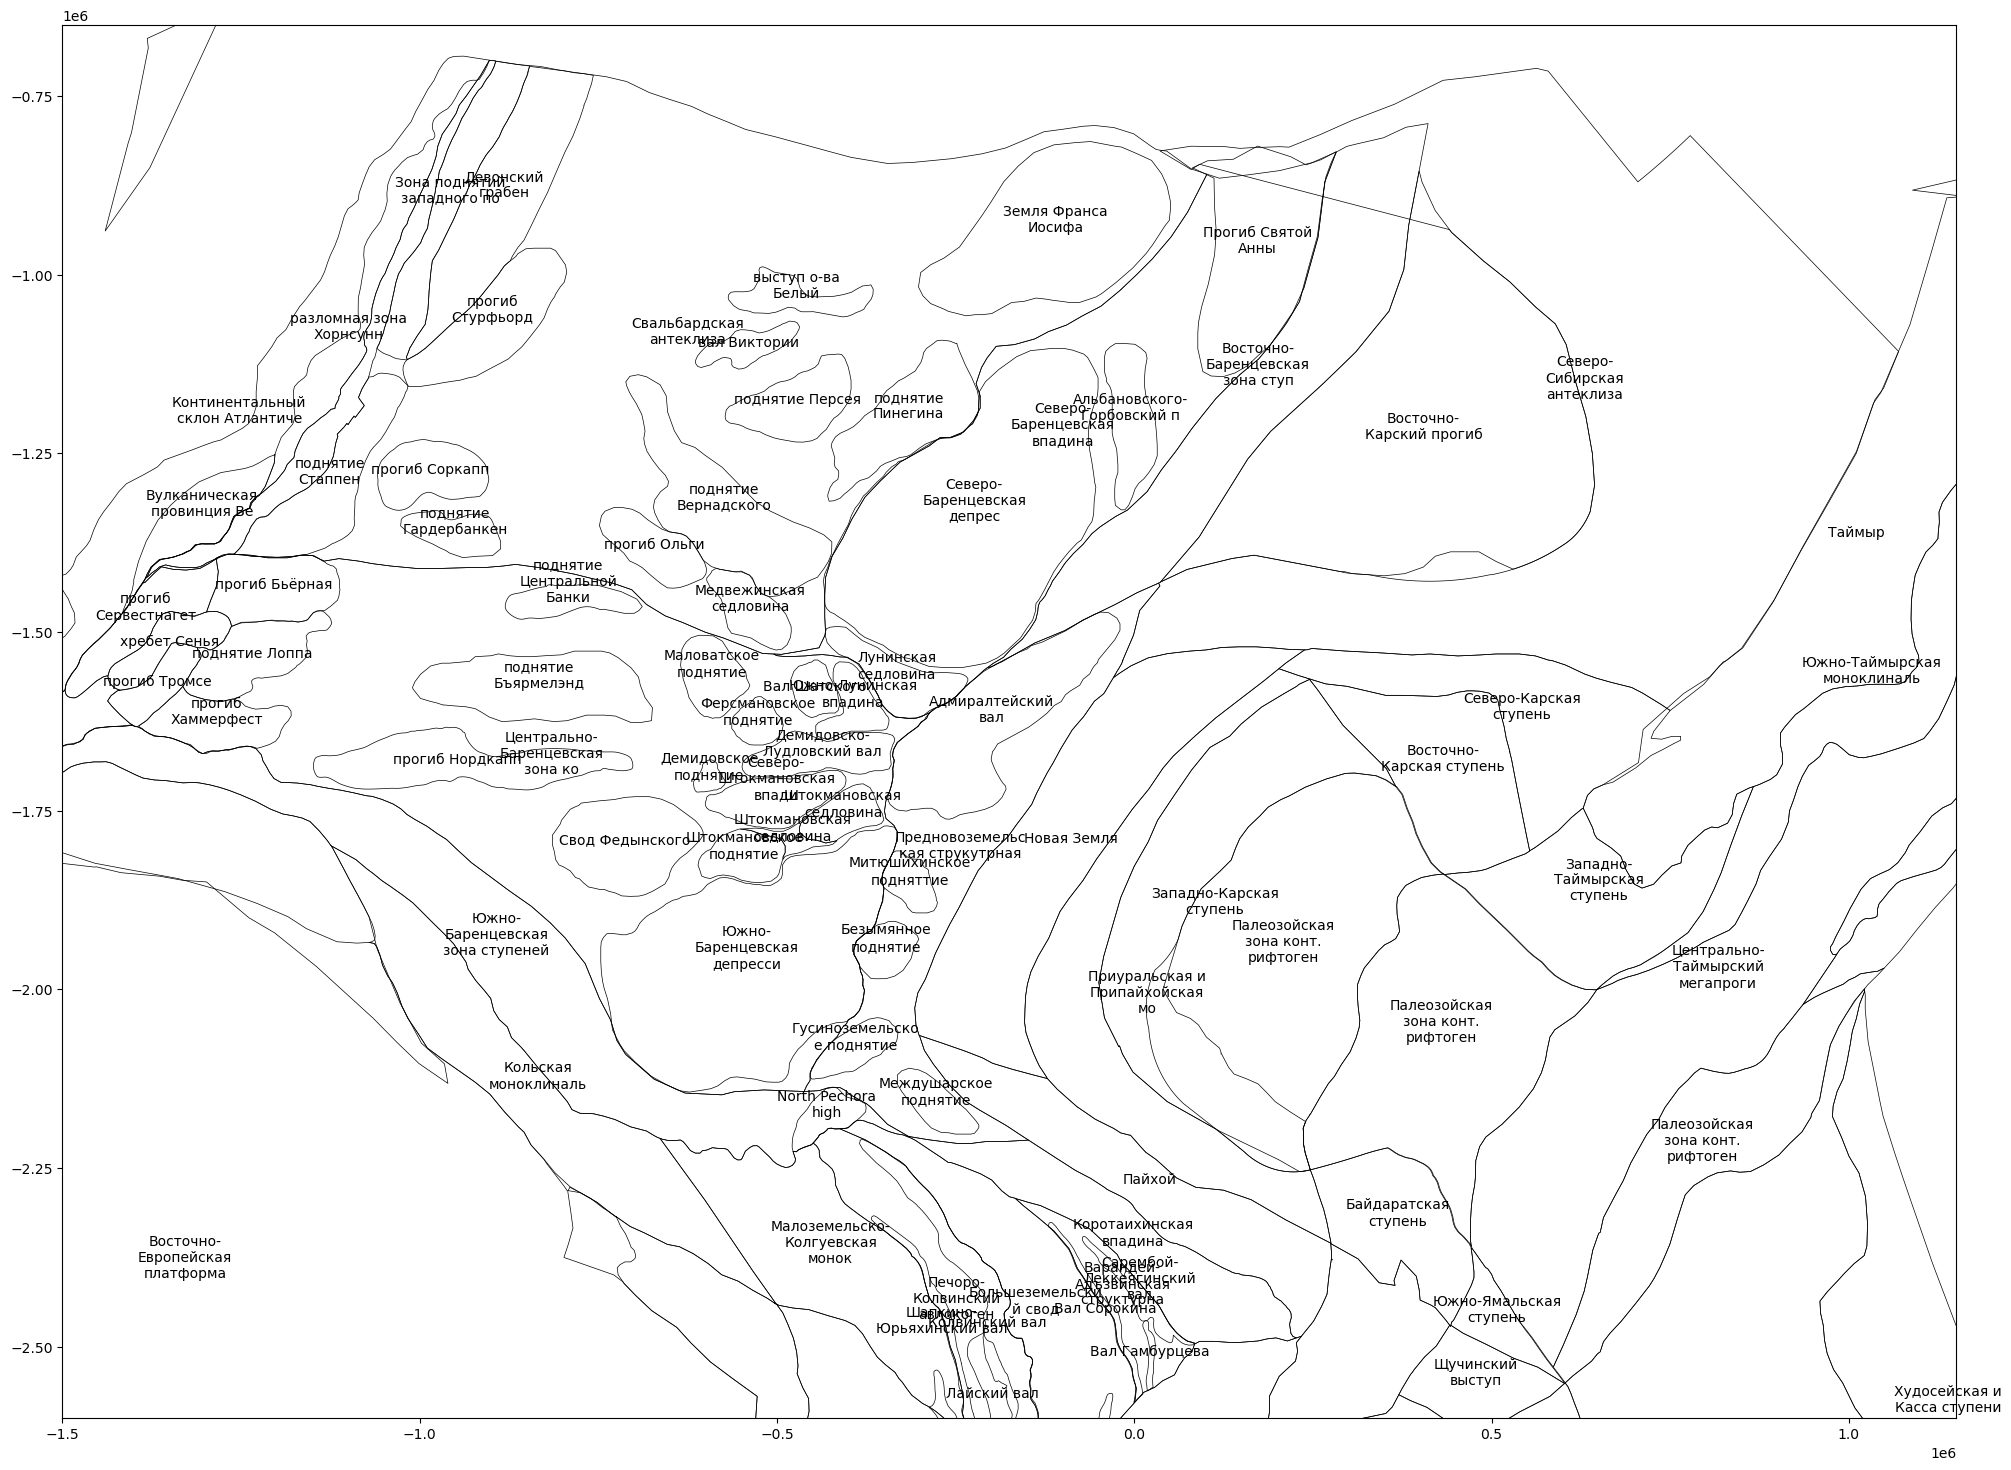

In [293]:
fig

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')

In [ ]:
wells_older = gpd.read_file("../Карты/Extra Layers/J3 Wells and older/J3_and_older.shp")
outcrops = gpd.read_file("../Карты/Extra Layers/Выходы J3 пород/J.shp")
land = gpd.read_file("../Карты/Extra Layers/Countries IRIS21/Countries_IRIS21_Intersect_2.shp")

In [ ]:
land.to_crs(crs).plot(edgecolor="black", facecolor="wheat", linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

In [ ]:
outcrops.to_crs(crs).plot(edgecolor="black", color="blue", linewidth=0.5, ax=ax);
legend_label.append(Patch(facecolor='blue', edgecolor='black', label=fill("Выходы юрских пород на поверхность", 20)))

<Figure size 640x480 with 0 Axes>

In [ ]:
wells_older.to_crs(crs).plot(edgecolor="black", facecolor="black", linewidth=4, ax=ax)
legend_label.append(
    Line2D(
        [0],
        [0],
        marker="o",
        color="black",
        label=fill("Скважины, вскрывшие верхнеюрские отложения", 20),
        markerfacecolor="black",
        markersize=16,
        ls="",
    )
)

<Figure size 640x480 with 0 Axes>

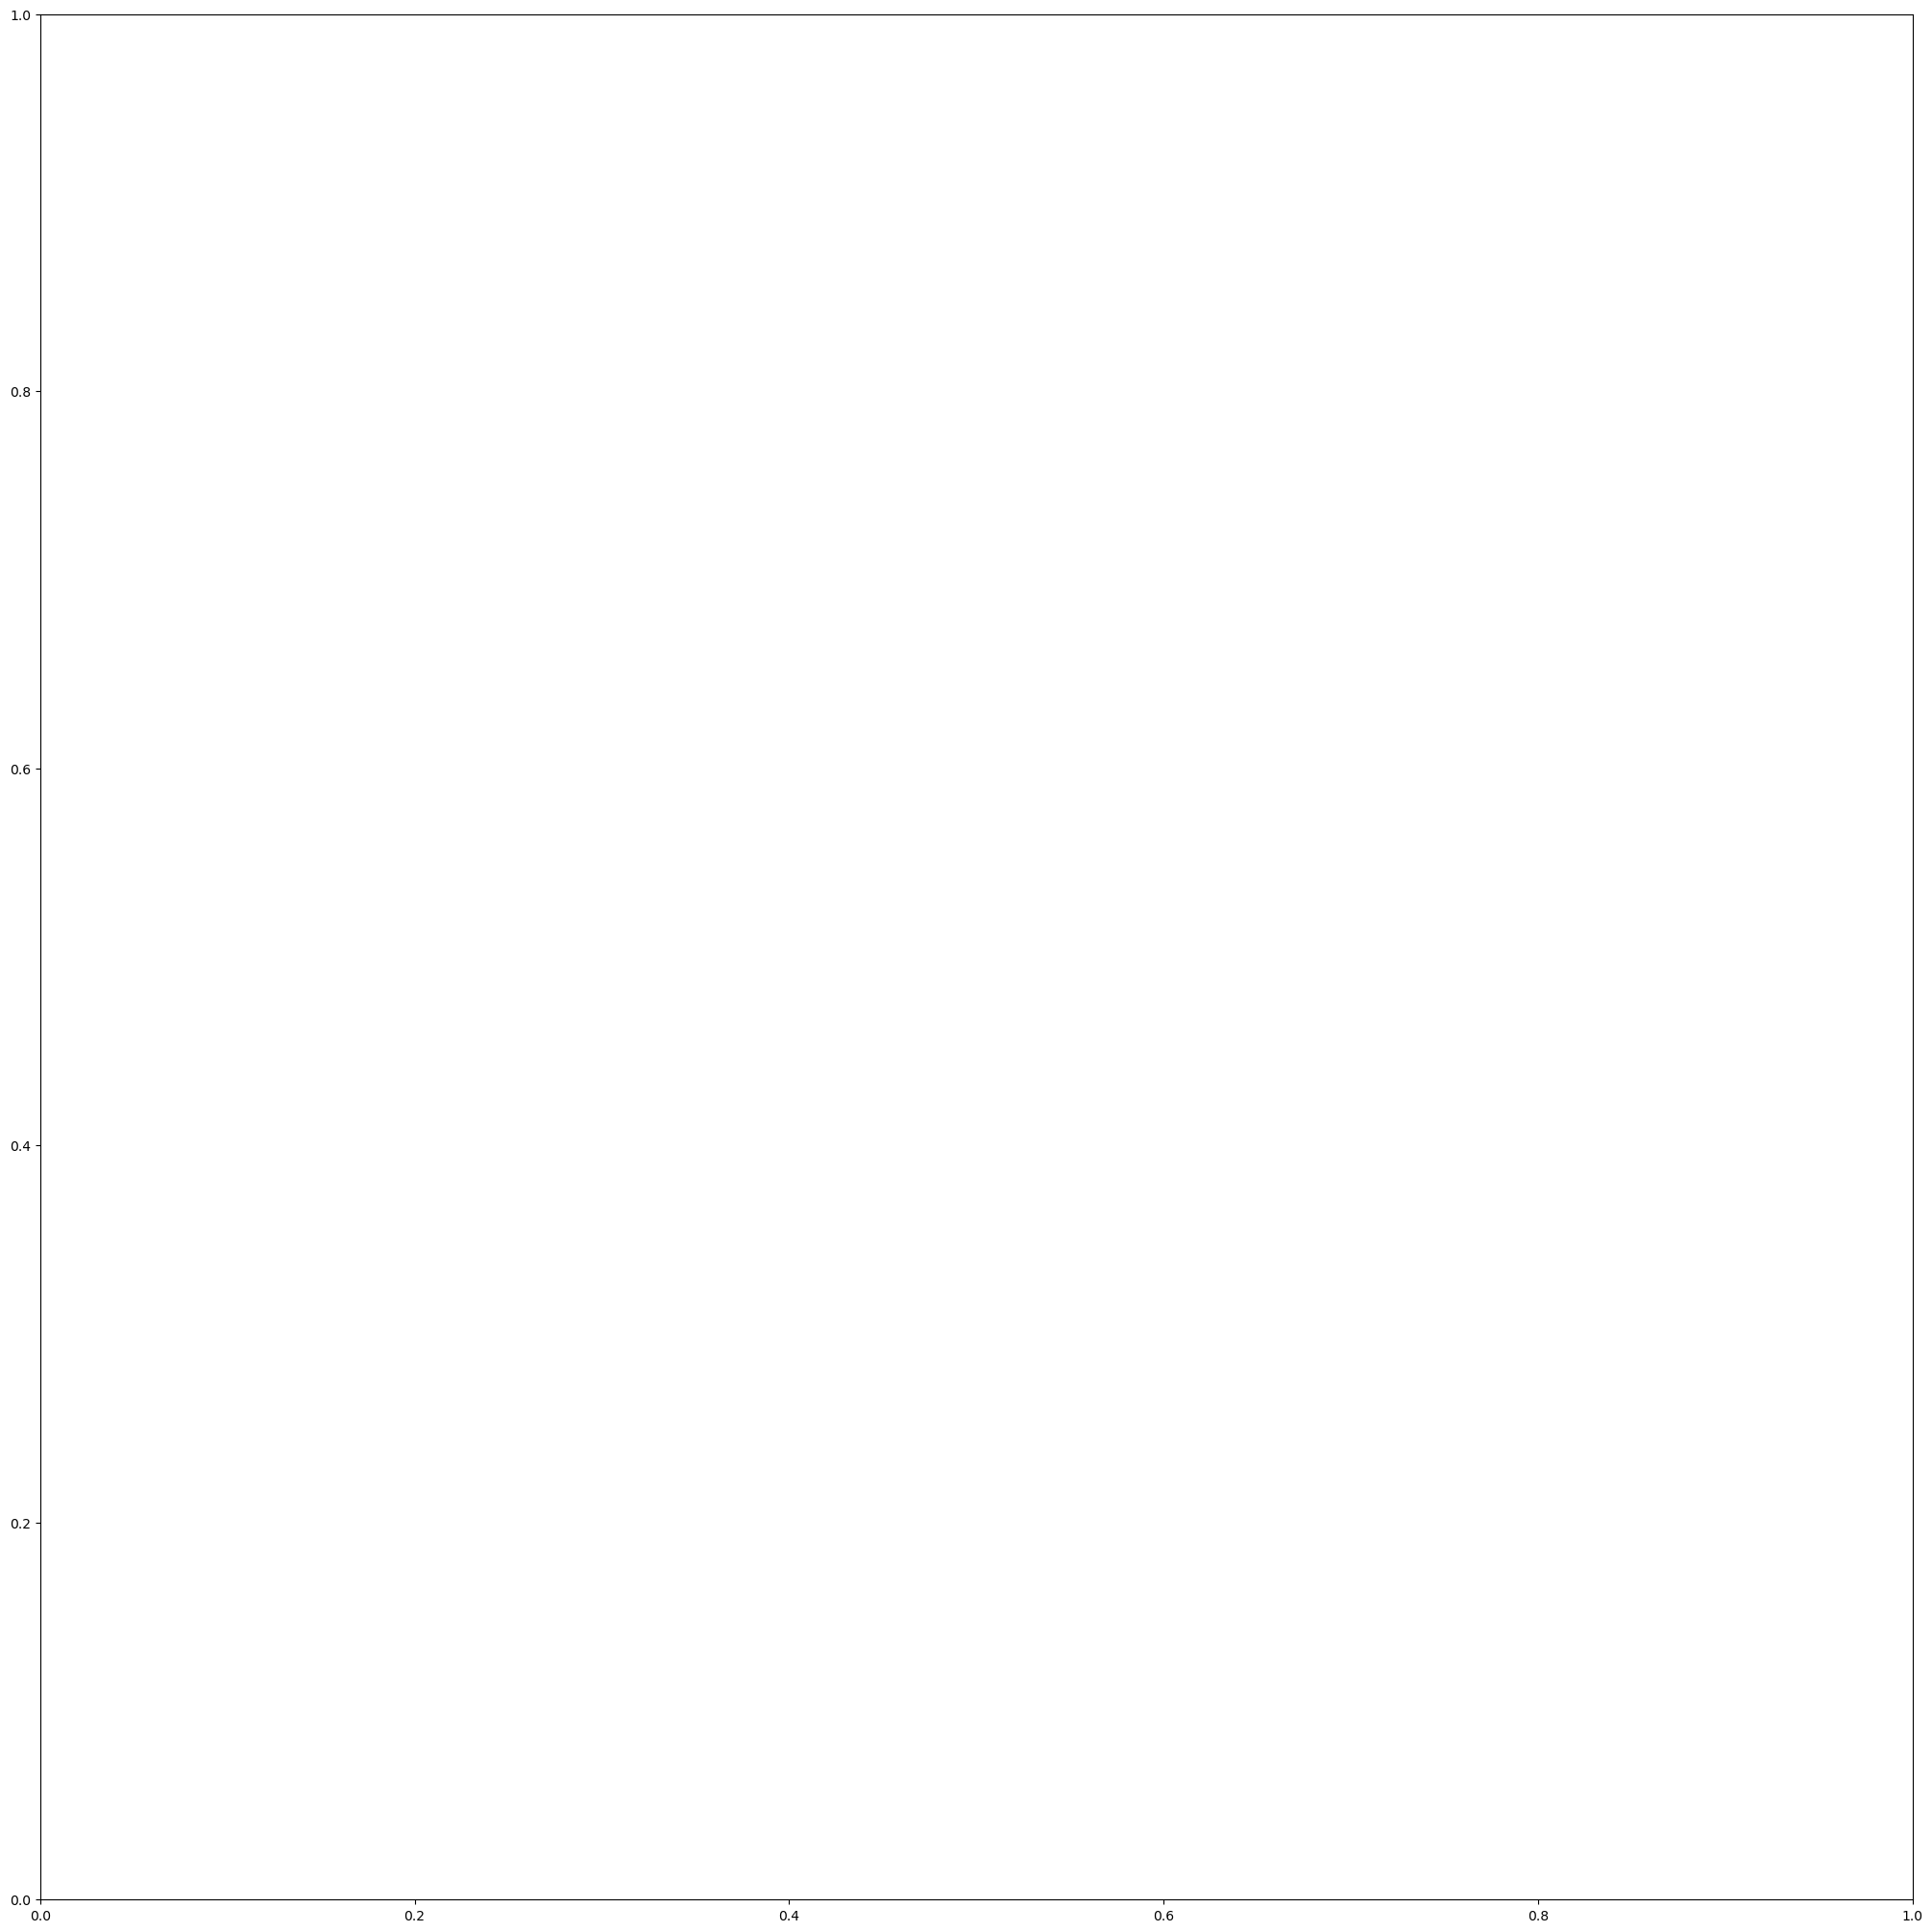

In [568]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')

In [569]:
wells_older.to_crs(crs).plot(edgecolor="black", facecolor="black", linewidth=4, ax=ax)

<Axes: >

<Figure size 640x480 with 0 Axes>

In [570]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

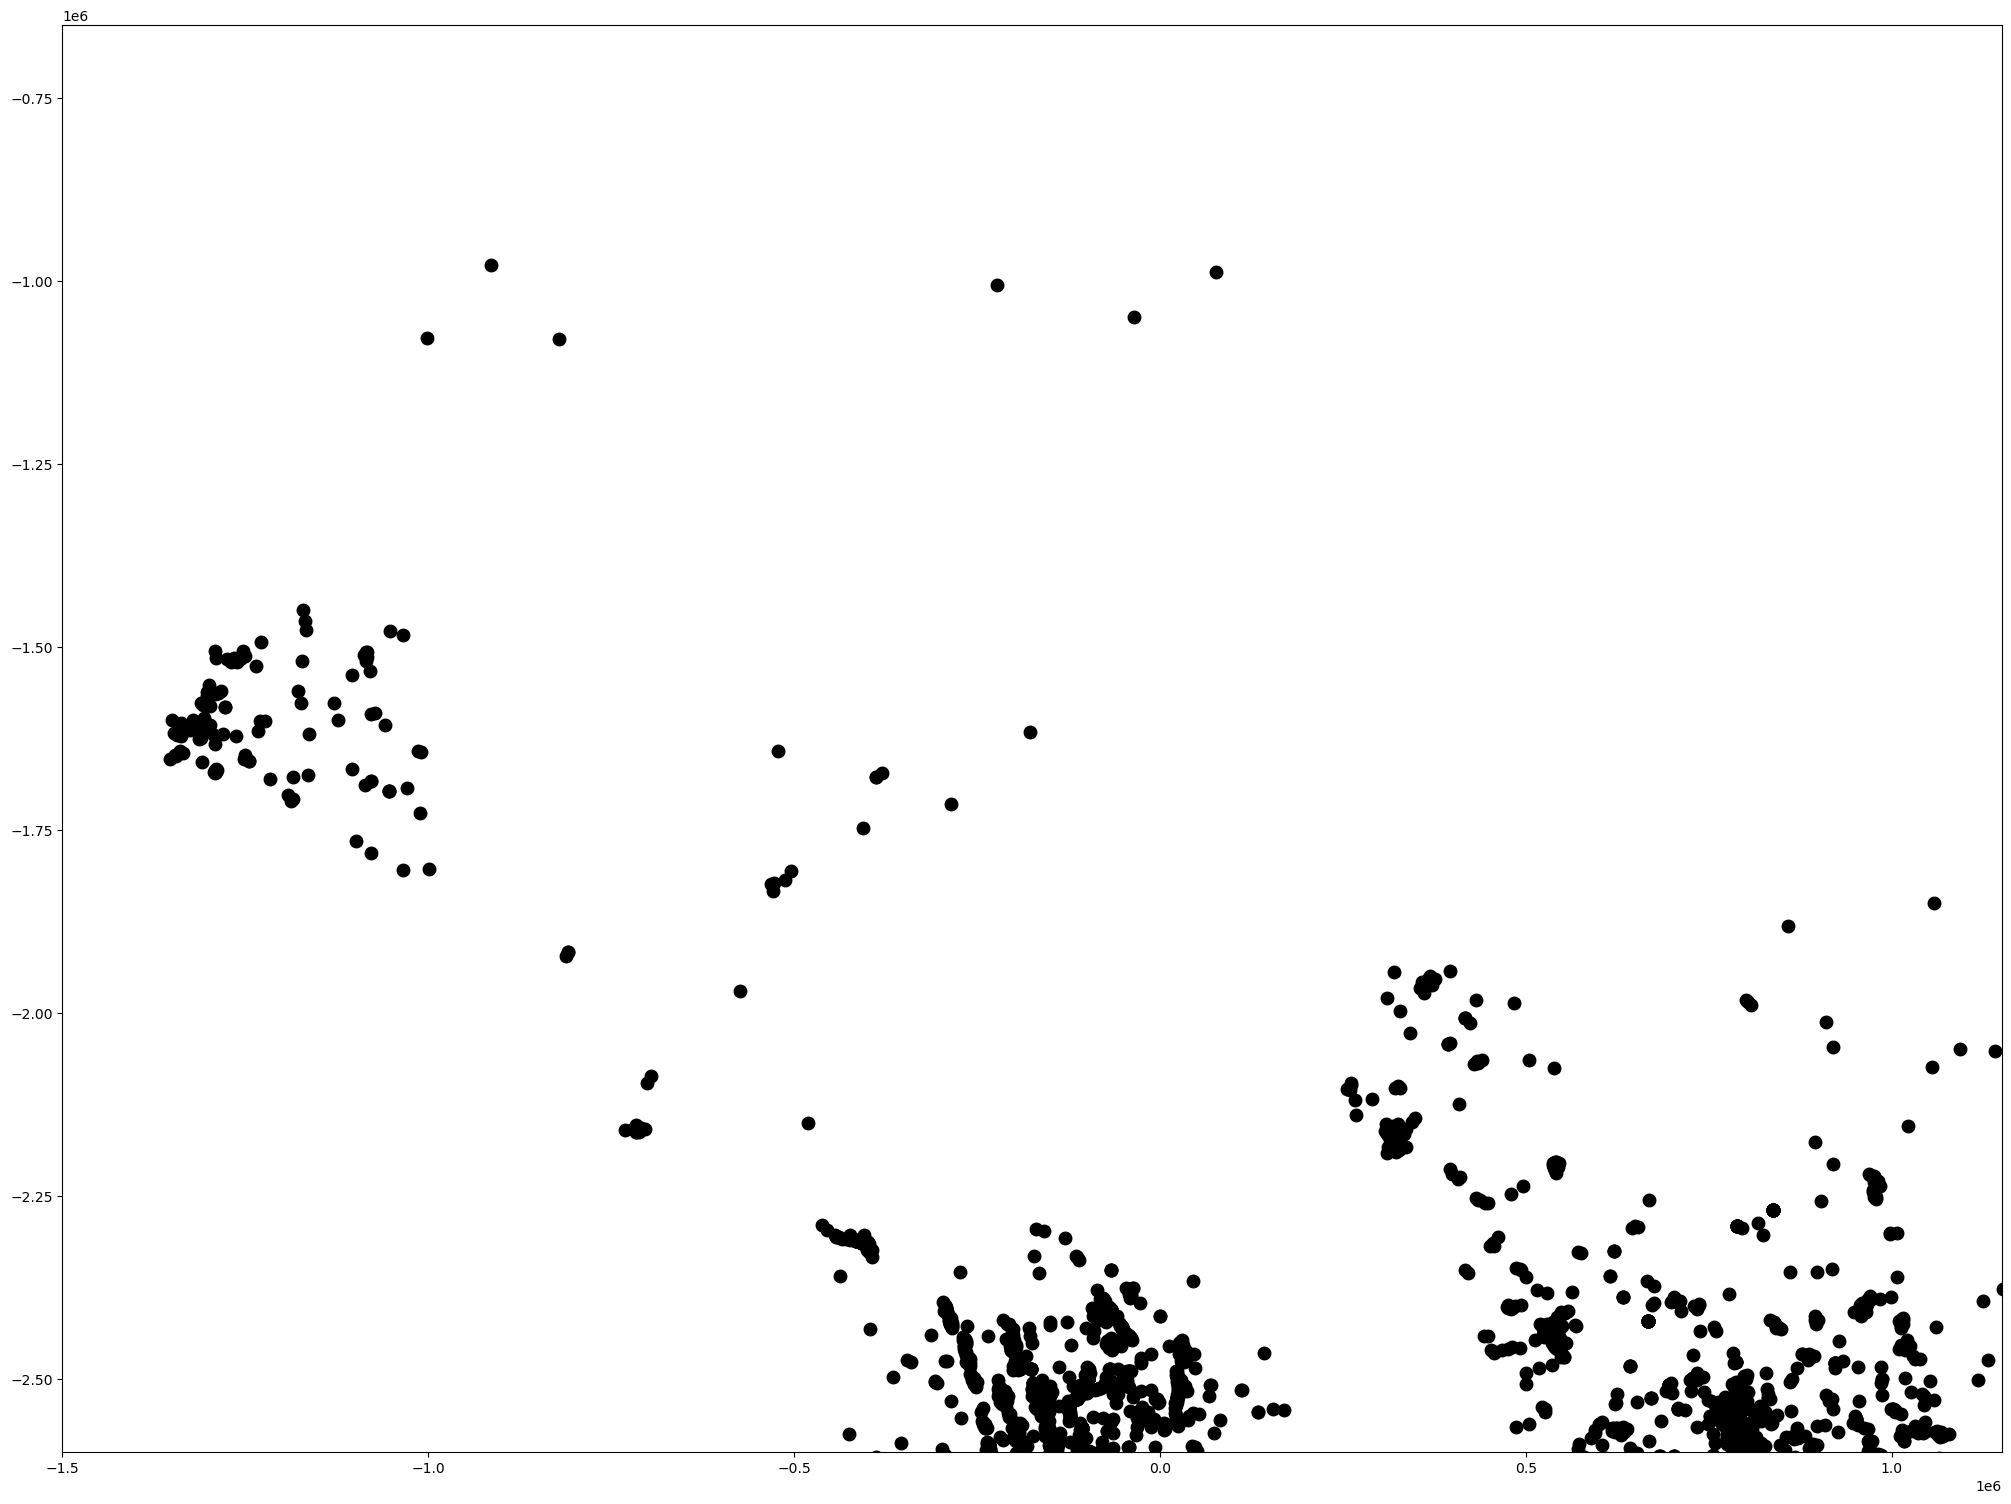

In [571]:
fig

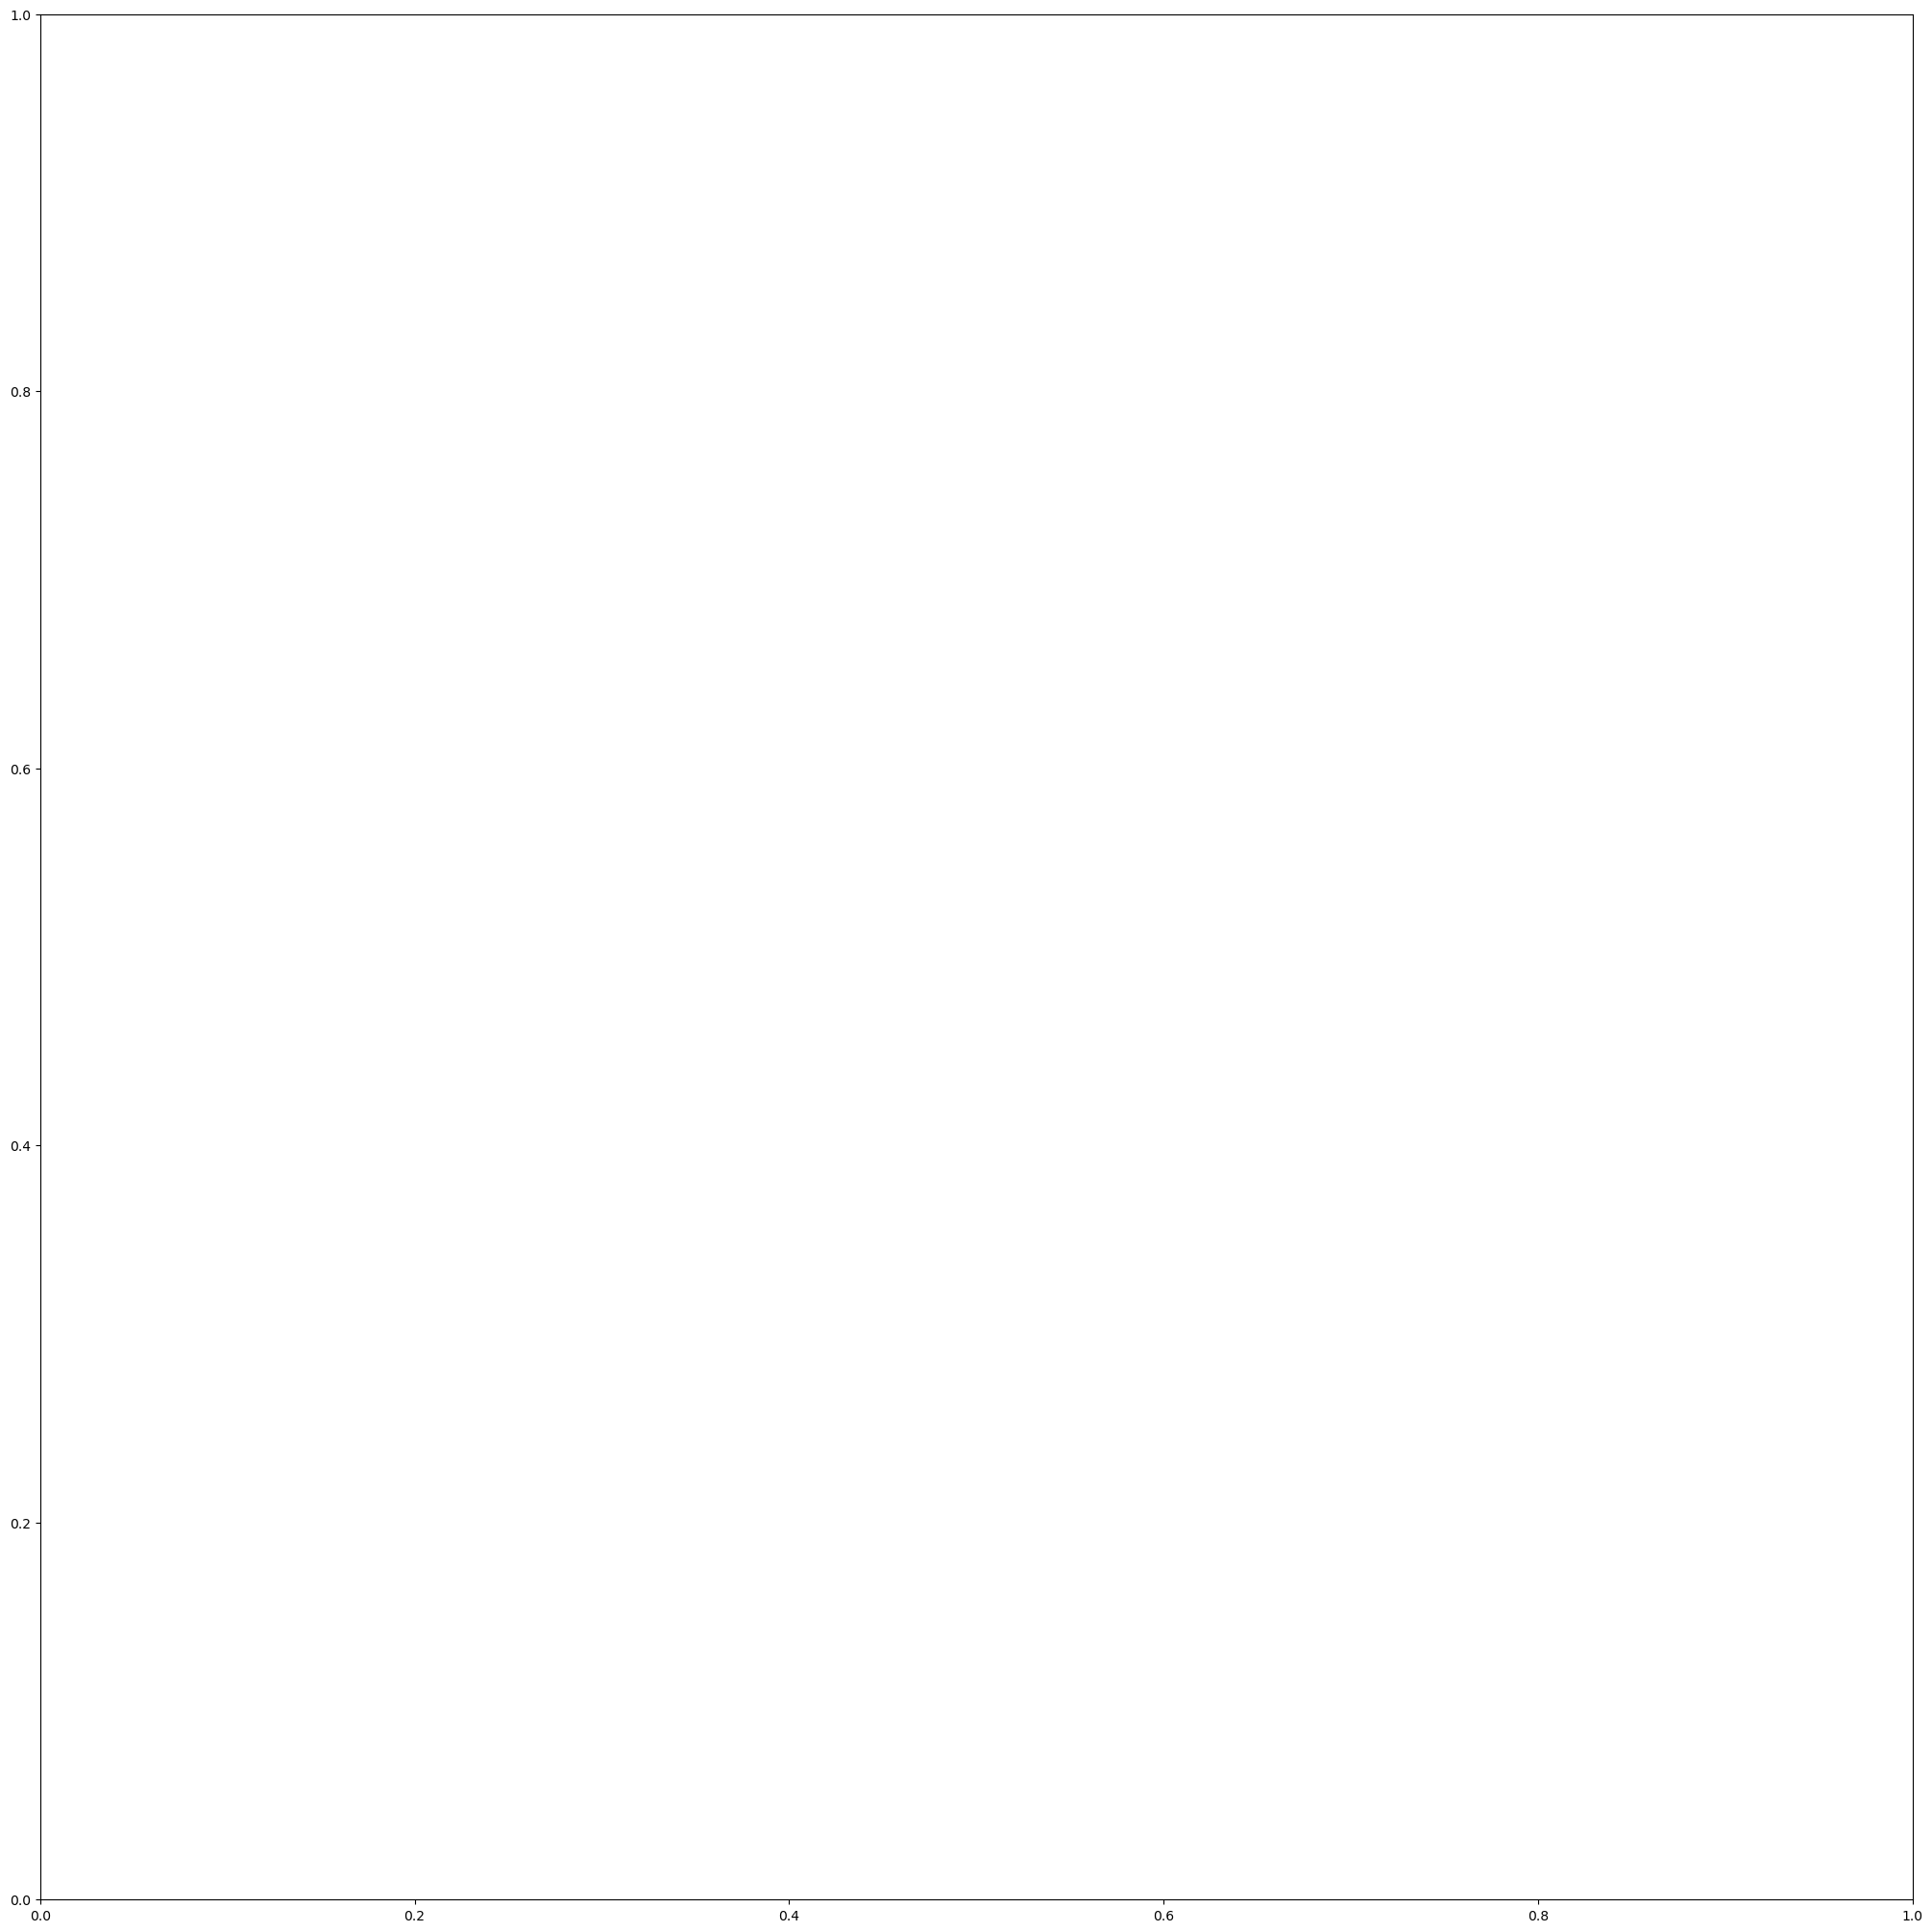

In [572]:
fig, ax = plt.subplots(figsize=(20, 20), layout='constrained')

In [573]:
ax.set_ylim(-2.6*1e6, -0.65*1e6);
ax.set_xlim(-1.5*1e6, 1.15*1e6);

In [574]:
outcrops.to_crs(crs).plot(edgecolor="black", color="blue", linewidth=0.5, ax=ax);

<Figure size 640x480 with 0 Axes>

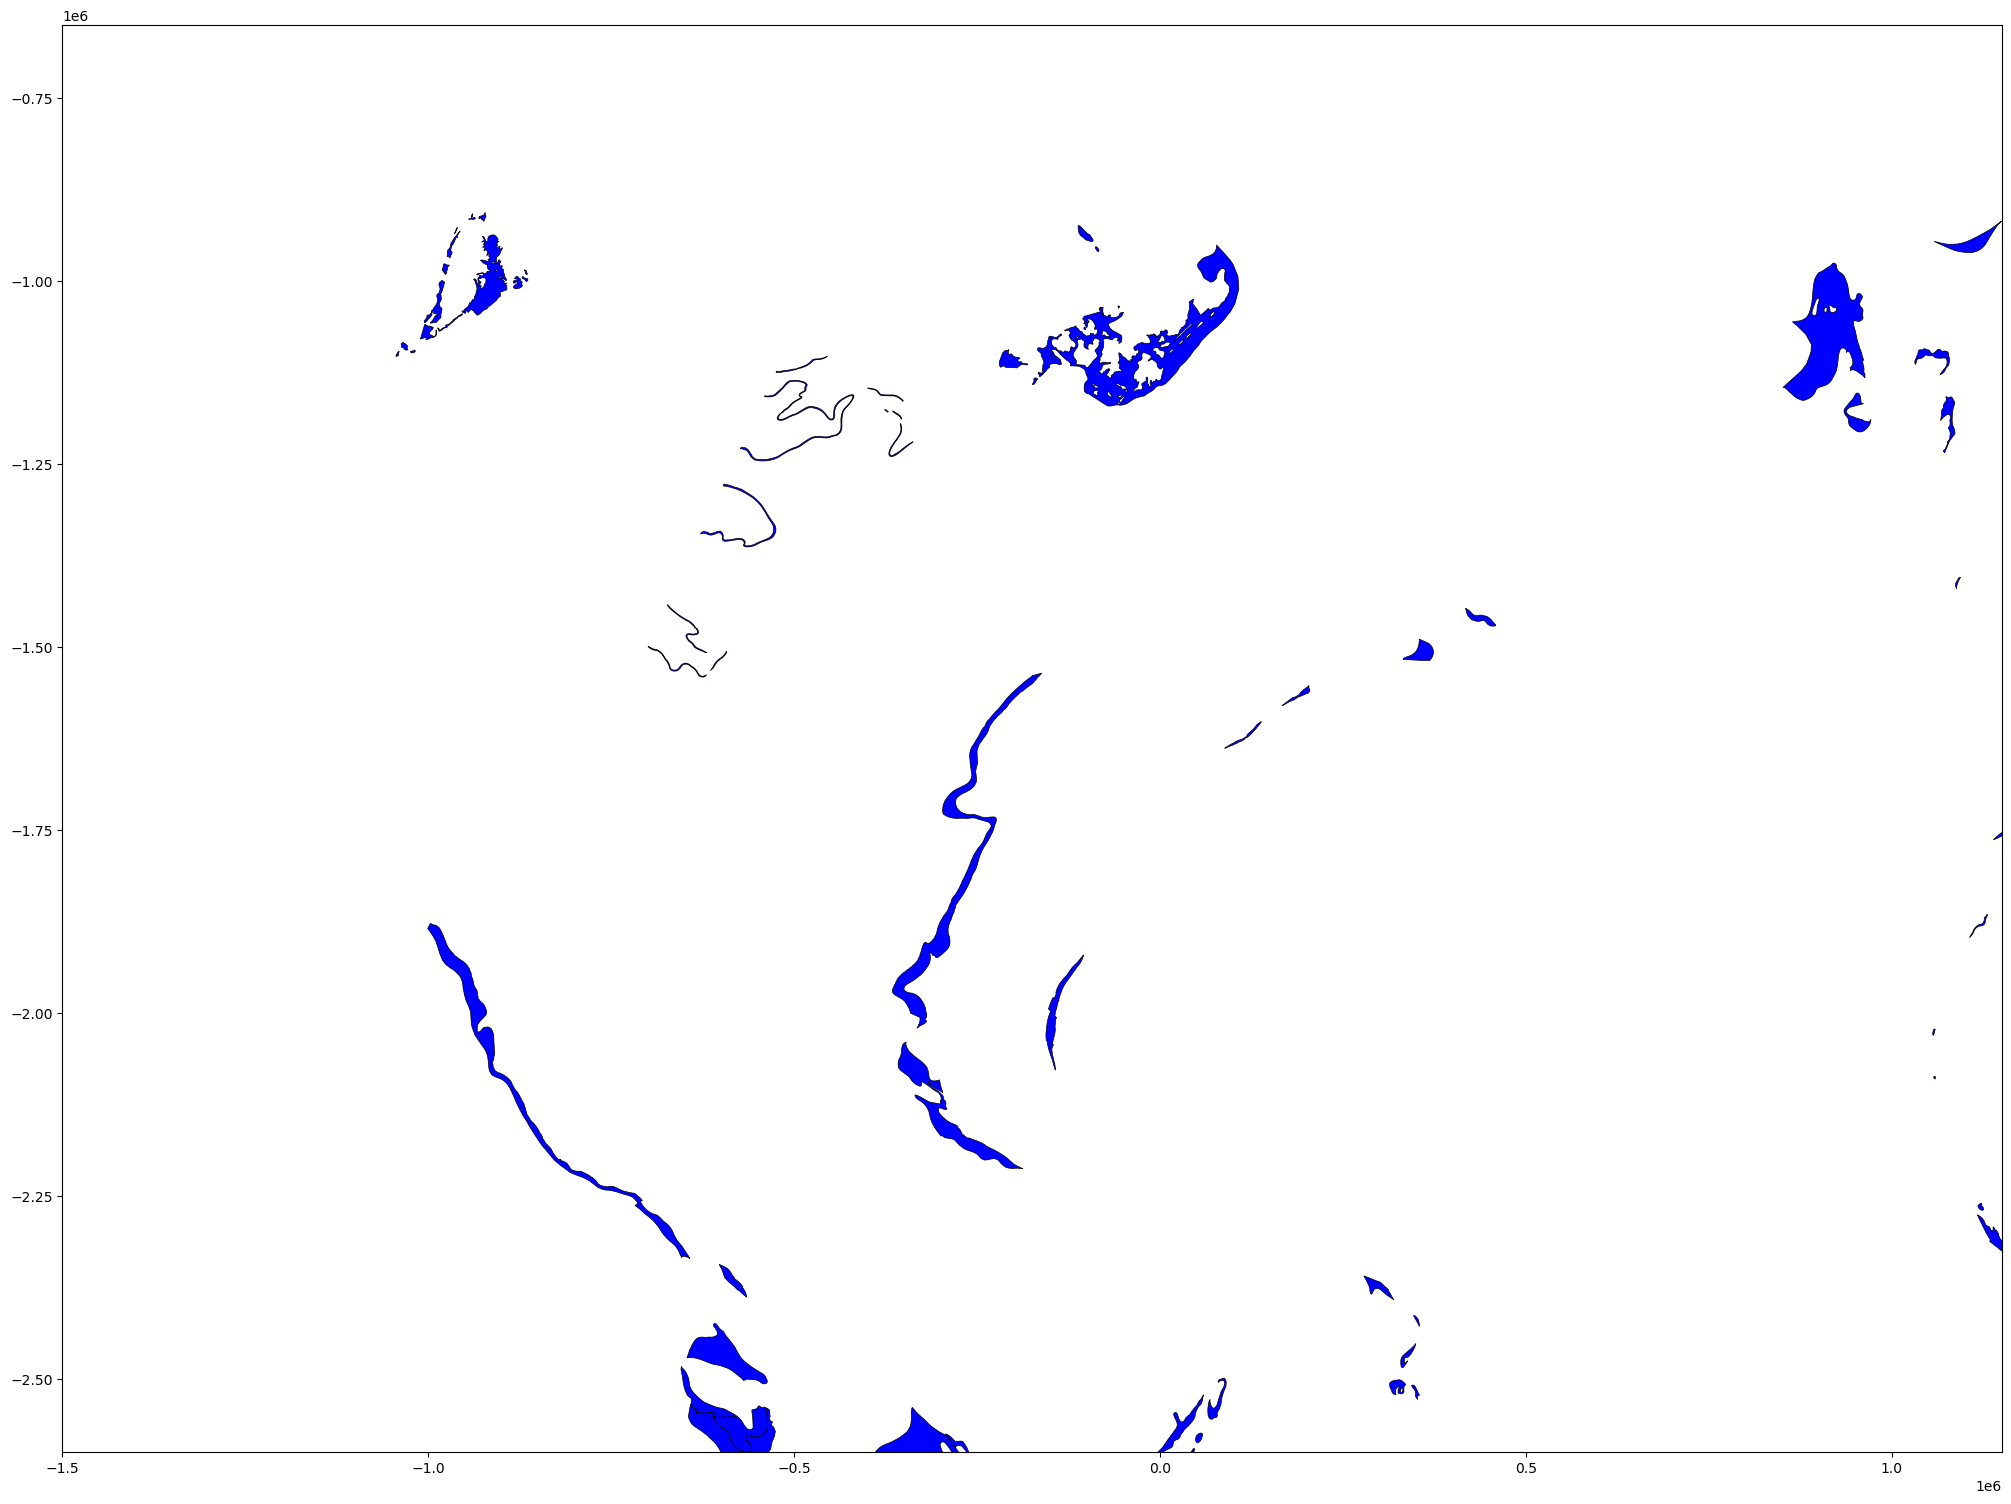

In [575]:
fig